In [12]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 600
from tqdm import tqdm
import gc

from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.decomposition import PCA

from keras.layers.normalization import BatchNormalization

from keras.models import Sequential, Model

from keras.layers import Input, Embedding, Dense, Activation, Dropout, Flatten

from keras import regularizers 

import keras

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GroupKFold
from pathlib import Path
import re

import warnings
import scipy
from datetime import timedelta

from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
def init():
    np.random.seed = 0
    
init()

In [4]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

def smape2D(y_true, y_pred):
    return smape(np.ravel(y_true), np.ravel(y_pred))

In [5]:
path = Path('../data/web-traffic')
list(path.iterdir())

[PosixPath('../data/web-traffic/key_1.csv'),
 PosixPath('../data/web-traffic/sample_submission_1.csv'),
 PosixPath('../data/web-traffic/sample_submission_2.csv'),
 PosixPath('../data/web-traffic/train_2.csv'),
 PosixPath('../data/web-traffic/key_2.csv'),
 PosixPath('../data/web-traffic/train_1.csv')]

In [17]:
train_all = pd.read_csv(path/"train_2.csv")
train_all.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,...,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-19,2016-11-20,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-

In [20]:
train_all.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04', '2017-09-05',
       '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-09', '2017-09-10'],
      dtype='object', length=804)

In [21]:
train_flattened = pd.melt(train_all[list(train_all.columns[-803:])+['Page']], 
                          id_vars='Page', var_name='date', value_name='Visits')

train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

In [22]:
train_flattened.head()

,Page,date,Visits,weekend
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,0.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,0.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,0.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,0.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,2015-07-01,NaN,0.0


In [28]:
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

df_mean   = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

df_std    = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].std())
df_std.columns = ['std']

train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median).join(df_std)
train_flattened.head()

,date,Visits,weekend,mean,median,std
Page,,,,,,
!vote_en.wikipedia.org_all-access_all-agents,2015-07-01,3.0,0.0,4967.229275,3.0,72676.416801
!vote_en.wikipedia.org_all-access_all-agents,2015-07-02,4.0,0.0,4967.229275,3.0,72676.416801
!vote_en.wikipedia.org_all-access_all-agents,2015-07-03,7.0,0.0,4967.229275,3.0,72676.416801
!vote_en.wikipedia.org_all-access_all-agents,2015-07-04,4.0,1.0,4967.229275,3.0,72676.416801
!vote_en.wikipedia.org_all-access_all-agents,2015-07-05,4.0,1.0,4967.229275,3.0,72676.416801


In [ ]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())
train_flattened['year'] = train_flattened.date.dt.year
train_flattened['month'] = train_flattened.date.dt.month
train_flattened['day'] = train_flattened.date.dt.day
train_flattened.head()

## Aggregation & Visualisation

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


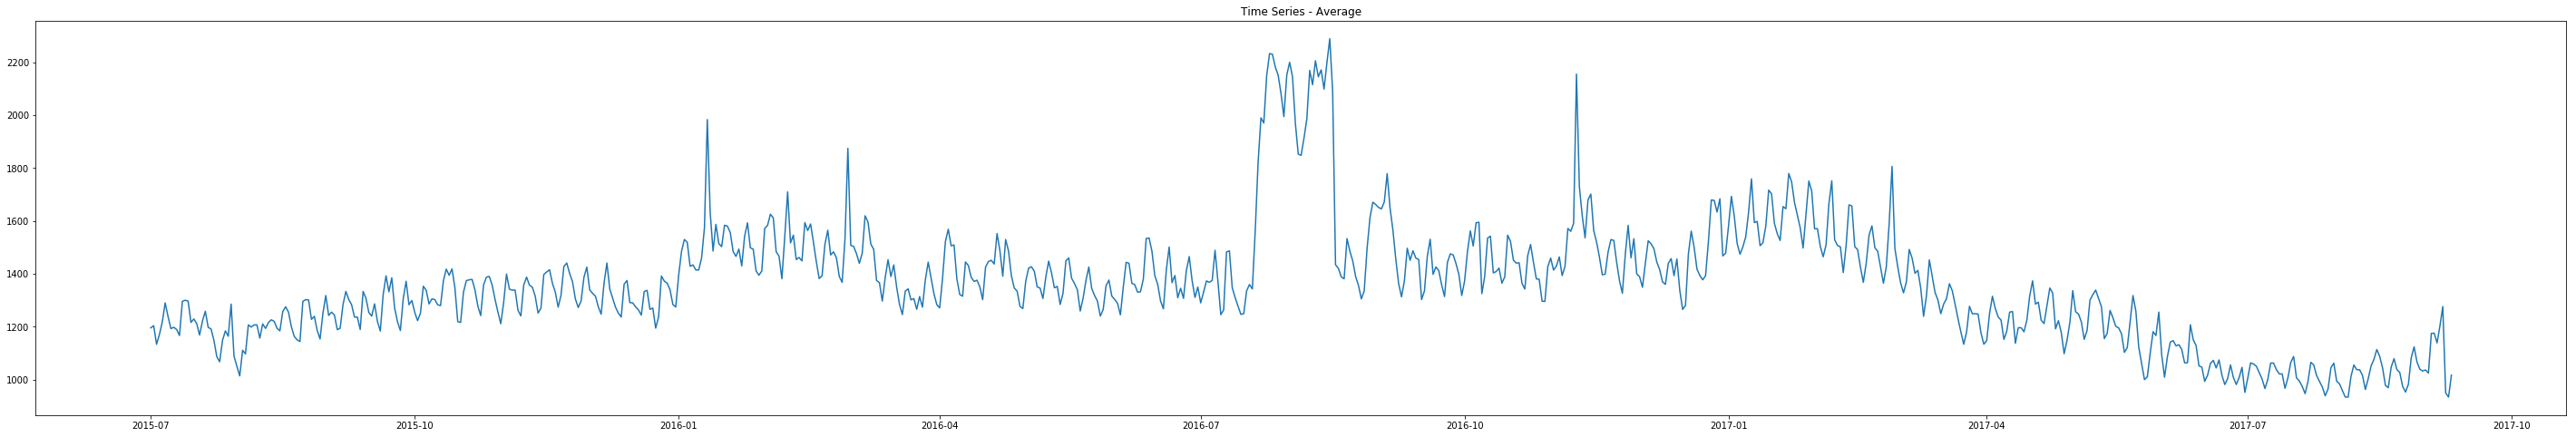

In [23]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page', 'date', 'Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

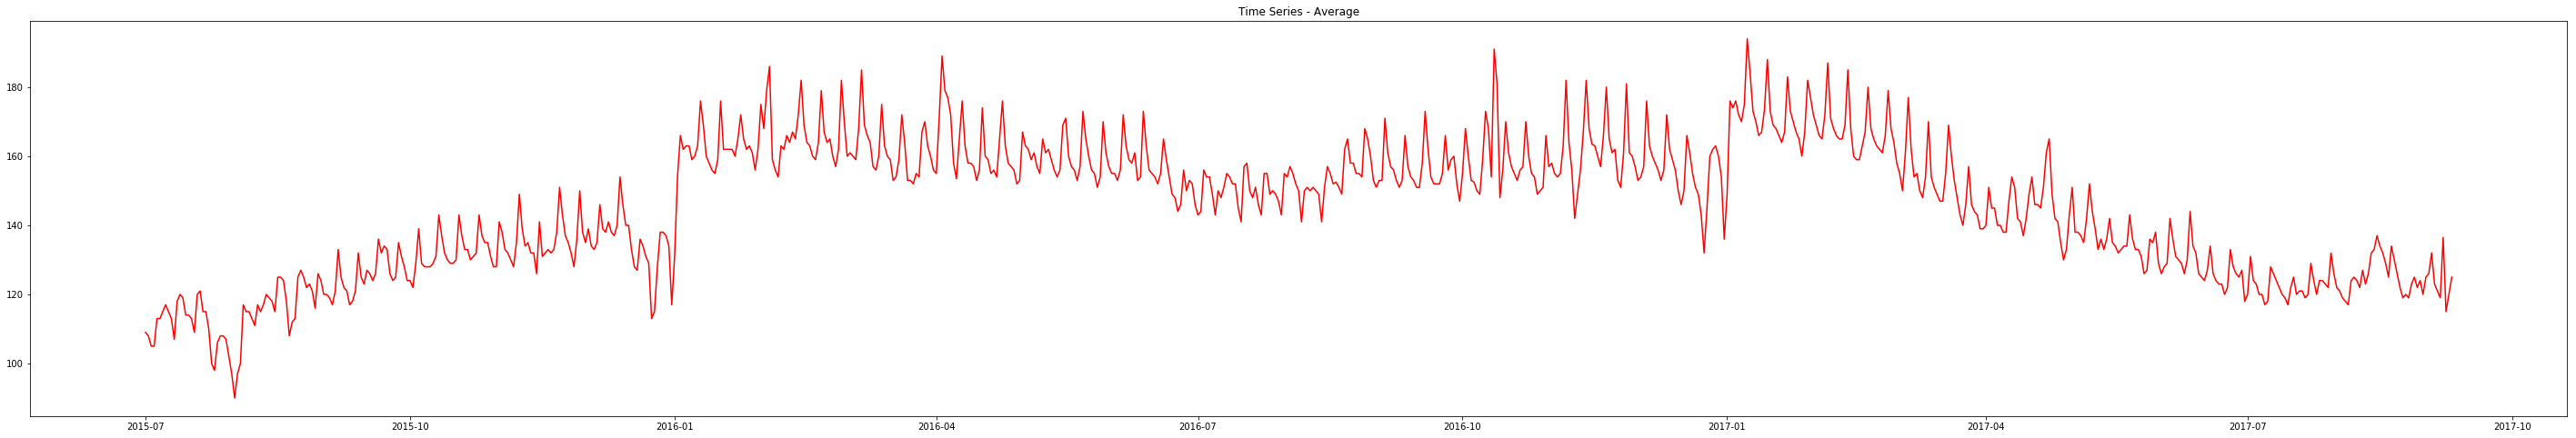

In [24]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page', 'date', 'Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color='r')
plt.title('Time Series - Average')
plt.show()

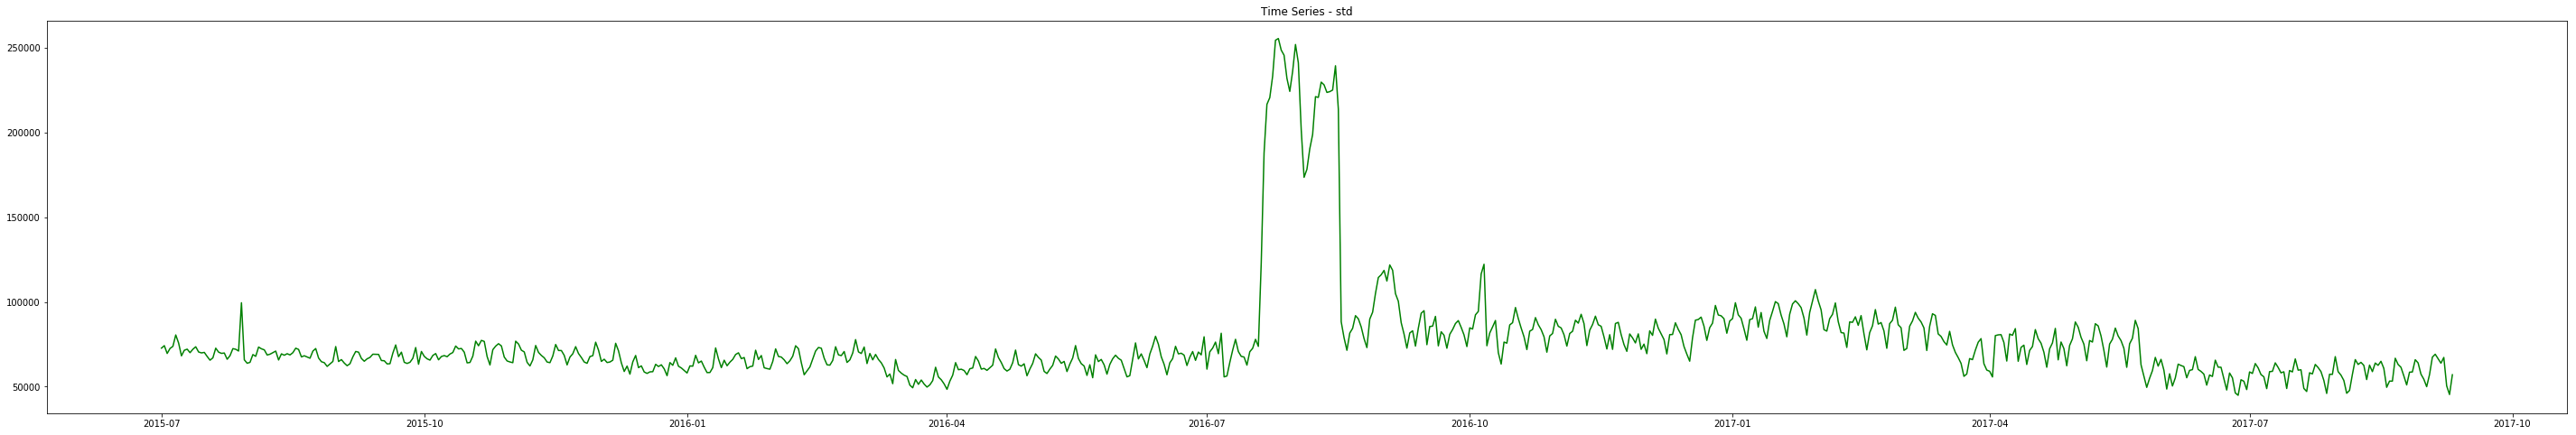

In [25]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [27]:
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('12', '12 - December', inplace=True)
train_flattened['month'].replace('11', '11 - November', inplace=True)
train_flattened['month'].replace('10', '10 - October', inplace=True)
train_flattened['month'].replace('09', '09 - September', inplace=True)
train_flattened['month'].replace('08', '08 - August', inplace=True)
train_flattened['month'].replace('07', '07 - July', inplace=True)
train_flattened['month'].replace('06', '06 - June', inplace=True)
train_flattened['month'].replace('05', '05 - May', inplace=True)
train_flattened['month'].replace('04', '04 - April', inplace=True)
train_flattened['month'].replace('03', '03 - March', inplace=True)
train_flattened['month'].replace('02', '02 - February', inplace=True)
train_flattened['month'].replace('01', '01 - January', inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

KeyError: 'month'

In [26]:
train_group = train_flattened.groupby(['month', 'weekday'])['Visits'].mean().reset_index()

train_group = train_group.pivot('weekday', 'month', 'Visits')
train_group.sort_index(inplace=True)

KeyError: 'month'

In [8]:
all_page = train_all.Page.copy()
train_key = train_all[['Page']].copy()
train_all = train_all.iloc[:,1:] 
train_all.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,...,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-19,2016-11-20,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,20

In [9]:
date_idx = dict((c, i) for i, c in enumerate(train_all.columns))

In [10]:
date_idx['2016-09-13']

440

In [11]:

date_idx['2017-09-10'] - date_idx['2016-09-10']

365

In [13]:
trains = []
tests = []
train_end = get_date_index('2016-09-10') + 1
test_start = get_date_index('2016-09-13')

for i in range(-3,4):
    train = train_all.iloc[ : , (train_end - max_size + i) : train_end + i].copy().astype('float32')
    test = train_all.iloc[:, test_start + i : (63 + test_start) + i].copy().astype('float32')
    train = train.iloc[:,::-1].copy().astype('float32')
    trains.append(train)
    tests.append(test)

train_all = train_all.iloc[:,-(max_size):].astype('float32')
train_all = train_all.iloc[:,::-1].copy().astype('float32')

test_3_date = tests[3].columns

In [14]:
train_all.head()

,2017-09-10,2017-09-09,2017-09-08,2017-09-07,2017-09-06,2017-09-05,2017-09-04,2017-09-03,2017-09-02,2017-09-01,2017-08-31,2017-08-30,2017-08-29,2017-08-28,2017-08-27,2017-08-26,2017-08-25,2017-08-24,2017-08-23,2017-08-22,2017-08-21,2017-08-20,2017-08-19,2017-08-18,2017-08-17,2017-08-16,2017-08-15,2017-08-14,2017-08-13,2017-08-12,2017-08-11,2017-08-10,2017-08-09,2017-08-08,2017-08-07,2017-08-06,2017-08-05,2017-08-04,2017-08-03,2017-08-02,2017-08-01,2017-07-31,2017-07-30,2017-07-29,2017-07-28,2017-07-27,2017-07-26,2017-07-25,2017-07-24,2017-07-23,2017-07-22,2017-07-21,2017-07-20,2017-07-19,2017-07-18,2017-07-17,2017-07-16,2017-07-15,2017-07-14,2017-07-13,2017-07-12,2017-07-11,2017-07-10,2017-07-09,2017-07-08,2017-07-07,2017-07-06,2017-07-05,2017-07-04,2017-07-03,2017-07-02,2017-07-01,2017-06-30,2017-06-29,2017-06-28,2017-06-27,2017-06-26,2017-06-25,2017-06-24,2017-06-23,2017-06-22,2017-06-21,2017-06-20,2017-06-19,2017-06-18,2017-06-17,2017-06-16,2017-06-15,2017-06-14,2017-06-13,2017-06-12,2017-06-11,2017-06-10,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03,2017-06-02,2017-06-01,2017-05-31,2017-05-30,2017-05-29,2017-05-28,2017-05-27,2017-05-26,2017-05-25,2017-05-24,2017-05-23,2017-05-22,2017-05-21,2017-05-20,2017-05-19,2017-05-18,2017-05-17,2017-05-16,2017-05-15,2017-05-14,2017-05-13,2017-05-12,2017-05-11,2017-05-10,2017-05-09,2017-05-08,2017-05-07,2017-05-06,2017-05-05,2017-05-04,2017-05-03,2017-05-02,2017-05-01,2017-04-30,2017-04-29,2017-04-28,2017-04-27,2017-04-26,2017-04-25,2017-04-24,2017-04-23,2017-04-22,2017-04-21,2017-04-20,2017-04-19,2017-04-18,2017-04-17,2017-04-16,2017-04-15,2017-04-14,2017-04-13,2017-04-12,2017-04-11,2017-04-10,2017-04-09,2017-04-08,2017-04-07,2017-04-06,2017-04-05,2017-04-04,2017-04-03,2017-04-02,2017-04-01,2017-03-31,2017-03-30,2017-03-29,2017-03-28,2017-03-27,2017-03-26,2017-03-25,2017-03-24,2017-03-23,2017-03-22,2017-03-21,2017-03-20,2017-03-19,2017-03-18,2017-03-17,2017-03-16,2017-03-15,2017-03-14
0,19.0,27.0,11.5,14.5,13.5,8.0,9.0,16.5,16.5,9.5,10.5,12.0,13.0,22.0,23.5,12.5,11.5,12.5,29.0,18.5,10.5,14.0,8.0,11.0,19.5,9.5,7.0,9.0,28.5,6.5,9.0,8.5,19.5,22.5,12.5,5.5,11.0,11.0,12.0,23.0,10.0,7.0,11.0,6.5,10.0,7.0,9.5,15.5,8.0,10.0,6.0,8.0,8.0,8.5,21.5,19.0,12.0,6.0,8.5,12.5,9.5,10.0,12.5,11.0,14.5,9.5,7.5,7.0,7.5,13.0,12.0,11.5,12.0,10.5,17.0,16.0,11.5,11.5,10.5,14.5,13.0,14.0,11.0,23.0,19.0,14.5,16.0,17.5,13.0,12.0,13.5,11.5,18.5,11.5,9.0,14.0,15.0,12.5,17.5,15.0,28.5,18.5,8.0,9.5,14.5,9.0,11.0,20.0,7.5,33.0,8.0,11.0,6.0,16.5,12.0,10.5,7.0,11.5,9.5,10.5,11.5,11.0,11.0,8.0,10.5,7.5,10.5,27.5,21.0,6.5,14.5,12.5,40.0,18.0,10.0,12.0,35.5,10.0,9.5,15.5,16.5,25.0,10.0,6.5,9.0,8.0,21.5,6.5,11.0,28.5,10.5,8.5,16.0,8.5,8.5,9.0,62.0,10.0,13.5,9.5,19.0,16.0,8.0,8.5,8.5,36.5,9.5,33.0,16.5,11.0,5.5,22.0,11.5,11.0,14.0,13.0,15.0,14.0,10.5,9.5,12.0
1,40.5,6.5,11.5,13.0,12.5,27.0,9.5,5.5,15.0,16.0,12.5,17.0,14.5,16.0,16.5,17.0,15.5,8.0,17.0,7.0,18.5,6.0,10.0,11.0,10.0,6.5,6.0,10.0,10.5,23.5,8.0,8.0,6.5,10.0,5.5,3.5,9.5,15.5,10.0,19.5,9.0,7.0,7.5,10.5,4.0,6.0,6.5,9.0,22.0,5.5,8.0,11.5,7.5,6.5,9.5,8.0,8.0,17.0,7.5,8.0,6.0,7.5,12.0,38.0,10.0,408.0,8.0,9.5,11.5,8.0,13.0,7.5,14.5,10.0,52.0,63.5,31.0,13.0,96.5,9.0,12.0,8.5,5.0,7.5,8.5,12.5,10.5,9.0,13.0,11.0,7.0,17.0,15.0,10.0,9.5,11.0,11.5,10.5,20.5,15.5,14.5,19.5,14.0,10.5,12.5,10.0,14.0,20.0,8.5,9.0,9.5,17.5,30.5,13.5,26.0,14.0,10.0,9.0,7.0,4.5,12.5,6.5,18.5,12.0,11.0,17.0,9.5,11.0,7.5,13.5,7.5,5.5,11.0,6.0,9.0,9.5,7.5,9.0,5.5,11.0,4.5,42.0,20.5,10.0,10.5,8.0,10.5,9.5,12.0,8.5,6.5,37.0,21.0,26.0,12.5,6.5,20.5,11.0,22.5,15.5,9.5,9.0,11.0,14.0,12.0,7.0,3.5,7.0,10.5,7.5,24.0,15.5,27.0,13.5,16.5,14.0,14.0,18.0,26.5,22.5,12.0
2,3.0,3.5,2.0,1.5,3.5,2.0,1.0,3.5,3.0,3.0,4.5,6.0,4.0,6.0,6.5,3.0,4.0,5.5,11.5,3.0,1.5,2.0,1.0,4.0,1.5,1.5,1.5,3.0,1.0,2.0,4.5,0.5,1.5,3.5,1.5,0.5,1.5,2.0,4.0,11.0,0.0,2.0,3.5,2.5,1.0,1.5,1.5,1.0,4.0,2.5,1.5,1.0,1.0,1.5,0.5,1.5,1.0,0.5,1.0,3.5,0.5,2.5,3.0,1.0,0.5,5.0,0.5,0.5,0.5,3.5,0.5,0.5,3.0,0.0,2.5,2.5,2.0,2.0,2.5,1

In [15]:
train_all.shape

(145063, 181)

In [16]:
trains[3].head()

,2016-09-10,2016-09-09,2016-09-08,2016-09-07,2016-09-06,2016-09-05,2016-09-04,2016-09-03,2016-09-02,2016-09-01,2016-08-31,2016-08-30,2016-08-29,2016-08-28,2016-08-27,2016-08-26,2016-08-25,2016-08-24,2016-08-23,2016-08-22,2016-08-21,2016-08-20,2016-08-19,2016-08-18,2016-08-17,2016-08-16,2016-08-15,2016-08-14,2016-08-13,2016-08-12,2016-08-11,2016-08-10,2016-08-09,2016-08-08,2016-08-07,2016-08-06,2016-08-05,2016-08-04,2016-08-03,2016-08-02,2016-08-01,2016-07-31,2016-07-30,2016-07-29,2016-07-28,2016-07-27,2016-07-26,2016-07-25,2016-07-24,2016-07-23,2016-07-22,2016-07-21,2016-07-20,2016-07-19,2016-07-18,2016-07-17,2016-07-16,2016-07-15,2016-07-14,2016-07-13,2016-07-12,2016-07-11,2016-07-10,2016-07-09,2016-07-08,2016-07-07,2016-07-06,2016-07-05,2016-07-04,2016-07-03,2016-07-02,2016-07-01,2016-06-30,2016-06-29,2016-06-28,2016-06-27,2016-06-26,2016-06-25,2016-06-24,2016-06-23,2016-06-22,2016-06-21,2016-06-20,2016-06-19,2016-06-18,2016-06-17,2016-06-16,2016-06-15,2016-06-14,2016-06-13,2016-06-12,2016-06-11,2016-06-10,2016-06-09,2016-06-08,2016-06-07,2016-06-06,2016-06-05,2016-06-04,2016-06-03,2016-06-02,2016-06-01,2016-05-31,2016-05-30,2016-05-29,2016-05-28,2016-05-27,2016-05-26,2016-05-25,2016-05-24,2016-05-23,2016-05-22,2016-05-21,2016-05-20,2016-05-19,2016-05-18,2016-05-17,2016-05-16,2016-05-15,2016-05-14,2016-05-13,2016-05-12,2016-05-11,2016-05-10,2016-05-09,2016-05-08,2016-05-07,2016-05-06,2016-05-05,2016-05-04,2016-05-03,2016-05-02,2016-05-01,2016-04-30,2016-04-29,2016-04-28,2016-04-27,2016-04-26,2016-04-25,2016-04-24,2016-04-23,2016-04-22,2016-04-21,2016-04-20,2016-04-19,2016-04-18,2016-04-17,2016-04-16,2016-04-15,2016-04-14,2016-04-13,2016-04-12,2016-04-11,2016-04-10,2016-04-09,2016-04-08,2016-04-07,2016-04-06,2016-04-05,2016-04-04,2016-04-03,2016-04-02,2016-04-01,2016-03-31,2016-03-30,2016-03-29,2016-03-28,2016-03-27,2016-03-26,2016-03-25,2016-03-24,2016-03-23,2016-03-22,2016-03-21,2016-03-20,2016-03-19,2016-03-18,2016-03-17,2016-03-16,2016-03-15,2016-03-14
0,8.0,27.5,9.0,9.5,9.0,11.5,9.5,12.5,10.0,10.5,12.5,4.0,13.0,9.0,7.5,20.0,7.0,10.0,16.5,10.0,15.0,6.5,18.5,21.0,24.5,6.0,7.0,12.0,8.5,27.5,15.0,11.5,20.5,13.0,9.5,5.0,24.5,10.0,8.5,28.5,9.5,9.5,6.0,14.5,13.0,15.5,8.5,9.0,6.5,6.0,15.0,9.0,11.0,12.0,7.5,7.5,7.0,9.0,7.5,9.0,8.5,22.5,28.0,57.5,15.0,7.5,10.5,9.0,8.0,7.5,8.5,10.0,6.0,11.5,9.0,5.5,34.5,7.5,11.0,4.0,11.0,13.0,31.0,4.0,117.0,7.0,7.5,8.5,6.5,7.0,9.0,7.0,5.5,5.0,9.0,9.0,7.0,7.5,5.5,6.5,13.5,10.5,8.0,8.5,7.5,6.0,7.0,9.5,10.0,10.5,5.0,7.0,6.5,7.5,6.0,8.0,17.5,9.5,8.0,11.0,11.5,10.5,11.5,19.5,11.0,25.0,5.5,9.5,11.0,10.0,6.5,8.0,9.0,14.5,7.5,7.5,9.5,20.0,12.5,8.5,15.5,3.0,22.0,11.0,9.0,11.5,8.0,11.5,8.5,8.5,39.5,28.5,10.5,35.5,63.0,19.0,51.0,94.5,245.0,4.5,6.5,7.0,6.0,8.5,9.0,5.5,29.5,10.0,5.5,7.5,4.0,5.5,6.0,5.5,6.5,9.0,3.0,8.5,7.0,5.0,4.5
1,6.5,6.5,17.5,21.5,22.0,9.5,39.0,33.0,8.5,15.5,15.5,72.0,11.0,12.5,6.0,7.5,11.5,7.0,5.0,14.5,10.0,6.5,15.0,17.0,4.5,6.0,31.5,38.5,6.0,30.0,8.5,9.5,19.5,7.5,27.0,8.0,15.0,14.5,9.5,19.5,12.0,12.5,9.5,24.5,17.5,8.5,9.0,9.0,9.5,11.0,11.0,9.5,8.0,8.0,16.0,18.0,10.5,24.5,17.0,15.5,46.0,12.0,32.0,92.0,24.0,13.5,8.5,14.0,14.0,6.0,5.5,6.5,7.5,8.0,12.0,7.0,6.5,7.0,12.0,6.5,12.5,9.0,7.0,5.0,7.0,4.5,12.5,10.0,5.0,7.5,5.5,9.5,9.5,8.0,4.5,6.5,6.0,6.0,5.0,8.0,5.5,5.0,9.0,7.5,3.0,8.5,8.0,4.5,9.0,7.0,5.0,8.5,6.5,5.0,11.0,5.5,6.5,5.5,2.5,6.5,6.5,6.0,6.0,9.0,11.5,44.0,8.5,22.5,9.0,8.0,15.0,16.5,33.0,11.0,11.0,32.0,4.5,8.0,17.5,20.5,8.5,8.5,19.5,30.5,7.0,5.0,21.0,5.5,7.5,8.0,18.5,10.0,7.0,9.5,7.5,6.5,8.0,8.5,10.0,8.0,9.0,9.0,12.5,6.0,11.5,18.0,14.0,7.5,7.0,7.5,7.0,8.5,6.0,8.5,7.5,8.5,23.0,9.0,11.0,8.0,18.0
2,9.5,2.5,5.0,5.5,3.0,3.5,1.0,2.5,3.5,2.5,1.0,2.0,2.5,1.5,1.0,1.5,2.5,1.0,2.0,2.0,1.0,1.0,3.5,1.0,0.5,2.0,1.0,3.0,2.5,1.5,6.5,3.5,3.0,2.5,0.5,1.0,3.5,4.5,1.5,1.5,2.5,2.0,2.5,3.5,1.5,1.0,1.0,3.0,5.5,1.0,2.5,2.5,1.5,1.5,1.5,3.0,3.0,3.0,2.5,3.5,2.0,6.0,1.5,0.5,0.0,1.0,2.0,1.5,2.0,1.0,2.0,2.5,2.0,0.5,2.5,3.0,0.5,2.5,1.5,2.0,0.5,3.0,0.5,3.0,1.5,1.5,3.0,8.0,0.5,1.0,1.0,3.0,2.0,1.5,4.5,0.5,2.0,1.5,2.5,3.5,3.5

In [17]:
trains[3].shape

(145063, 181)

In [18]:
trains[0].head()

,2016-09-07,2016-09-06,2016-09-05,2016-09-04,2016-09-03,2016-09-02,2016-09-01,2016-08-31,2016-08-30,2016-08-29,2016-08-28,2016-08-27,2016-08-26,2016-08-25,2016-08-24,2016-08-23,2016-08-22,2016-08-21,2016-08-20,2016-08-19,2016-08-18,2016-08-17,2016-08-16,2016-08-15,2016-08-14,2016-08-13,2016-08-12,2016-08-11,2016-08-10,2016-08-09,2016-08-08,2016-08-07,2016-08-06,2016-08-05,2016-08-04,2016-08-03,2016-08-02,2016-08-01,2016-07-31,2016-07-30,2016-07-29,2016-07-28,2016-07-27,2016-07-26,2016-07-25,2016-07-24,2016-07-23,2016-07-22,2016-07-21,2016-07-20,2016-07-19,2016-07-18,2016-07-17,2016-07-16,2016-07-15,2016-07-14,2016-07-13,2016-07-12,2016-07-11,2016-07-10,2016-07-09,2016-07-08,2016-07-07,2016-07-06,2016-07-05,2016-07-04,2016-07-03,2016-07-02,2016-07-01,2016-06-30,2016-06-29,2016-06-28,2016-06-27,2016-06-26,2016-06-25,2016-06-24,2016-06-23,2016-06-22,2016-06-21,2016-06-20,2016-06-19,2016-06-18,2016-06-17,2016-06-16,2016-06-15,2016-06-14,2016-06-13,2016-06-12,2016-06-11,2016-06-10,2016-06-09,2016-06-08,2016-06-07,2016-06-06,2016-06-05,2016-06-04,2016-06-03,2016-06-02,2016-06-01,2016-05-31,2016-05-30,2016-05-29,2016-05-28,2016-05-27,2016-05-26,2016-05-25,2016-05-24,2016-05-23,2016-05-22,2016-05-21,2016-05-20,2016-05-19,2016-05-18,2016-05-17,2016-05-16,2016-05-15,2016-05-14,2016-05-13,2016-05-12,2016-05-11,2016-05-10,2016-05-09,2016-05-08,2016-05-07,2016-05-06,2016-05-05,2016-05-04,2016-05-03,2016-05-02,2016-05-01,2016-04-30,2016-04-29,2016-04-28,2016-04-27,2016-04-26,2016-04-25,2016-04-24,2016-04-23,2016-04-22,2016-04-21,2016-04-20,2016-04-19,2016-04-18,2016-04-17,2016-04-16,2016-04-15,2016-04-14,2016-04-13,2016-04-12,2016-04-11,2016-04-10,2016-04-09,2016-04-08,2016-04-07,2016-04-06,2016-04-05,2016-04-04,2016-04-03,2016-04-02,2016-04-01,2016-03-31,2016-03-30,2016-03-29,2016-03-28,2016-03-27,2016-03-26,2016-03-25,2016-03-24,2016-03-23,2016-03-22,2016-03-21,2016-03-20,2016-03-19,2016-03-18,2016-03-17,2016-03-16,2016-03-15,2016-03-14,2016-03-13,2016-03-12,2016-03-11
0,9.5,9.0,11.5,9.5,12.5,10.0,10.5,12.5,4.0,13.0,9.0,7.5,20.0,7.0,10.0,16.5,10.0,15.0,6.5,18.5,21.0,24.5,6.0,7.0,12.0,8.5,27.5,15.0,11.5,20.5,13.0,9.5,5.0,24.5,10.0,8.5,28.5,9.5,9.5,6.0,14.5,13.0,15.5,8.5,9.0,6.5,6.0,15.0,9.0,11.0,12.0,7.5,7.5,7.0,9.0,7.5,9.0,8.5,22.5,28.0,57.5,15.0,7.5,10.5,9.0,8.0,7.5,8.5,10.0,6.0,11.5,9.0,5.5,34.5,7.5,11.0,4.0,11.0,13.0,31.0,4.0,117.0,7.0,7.5,8.5,6.5,7.0,9.0,7.0,5.5,5.0,9.0,9.0,7.0,7.5,5.5,6.5,13.5,10.5,8.0,8.5,7.5,6.0,7.0,9.5,10.0,10.5,5.0,7.0,6.5,7.5,6.0,8.0,17.5,9.5,8.0,11.0,11.5,10.5,11.5,19.5,11.0,25.0,5.5,9.5,11.0,10.0,6.5,8.0,9.0,14.5,7.5,7.5,9.5,20.0,12.5,8.5,15.5,3.0,22.0,11.0,9.0,11.5,8.0,11.5,8.5,8.5,39.5,28.5,10.5,35.5,63.0,19.0,51.0,94.5,245.0,4.5,6.5,7.0,6.0,8.5,9.0,5.5,29.5,10.0,5.5,7.5,4.0,5.5,6.0,5.5,6.5,9.0,3.0,8.5,7.0,5.0,4.5,8.5,4.5,4.0
1,21.5,22.0,9.5,39.0,33.0,8.5,15.5,15.5,72.0,11.0,12.5,6.0,7.5,11.5,7.0,5.0,14.5,10.0,6.5,15.0,17.0,4.5,6.0,31.5,38.5,6.0,30.0,8.5,9.5,19.5,7.5,27.0,8.0,15.0,14.5,9.5,19.5,12.0,12.5,9.5,24.5,17.5,8.5,9.0,9.0,9.5,11.0,11.0,9.5,8.0,8.0,16.0,18.0,10.5,24.5,17.0,15.5,46.0,12.0,32.0,92.0,24.0,13.5,8.5,14.0,14.0,6.0,5.5,6.5,7.5,8.0,12.0,7.0,6.5,7.0,12.0,6.5,12.5,9.0,7.0,5.0,7.0,4.5,12.5,10.0,5.0,7.5,5.5,9.5,9.5,8.0,4.5,6.5,6.0,6.0,5.0,8.0,5.5,5.0,9.0,7.5,3.0,8.5,8.0,4.5,9.0,7.0,5.0,8.5,6.5,5.0,11.0,5.5,6.5,5.5,2.5,6.5,6.5,6.0,6.0,9.0,11.5,44.0,8.5,22.5,9.0,8.0,15.0,16.5,33.0,11.0,11.0,32.0,4.5,8.0,17.5,20.5,8.5,8.5,19.5,30.5,7.0,5.0,21.0,5.5,7.5,8.0,18.5,10.0,7.0,9.5,7.5,6.5,8.0,8.5,10.0,8.0,9.0,9.0,12.5,6.0,11.5,18.0,14.0,7.5,7.0,7.5,7.0,8.5,6.0,8.5,7.5,8.5,23.0,9.0,11.0,8.0,18.0,5.5,7.5,3.5
2,5.5,3.0,3.5,1.0,2.5,3.5,2.5,1.0,2.0,2.5,1.5,1.0,1.5,2.5,1.0,2.0,2.0,1.0,1.0,3.5,1.0,0.5,2.0,1.0,3.0,2.5,1.5,6.5,3.5,3.0,2.5,0.5,1.0,3.5,4.5,1.5,1.5,2.5,2.0,2.5,3.5,1.5,1.0,1.0,3.0,5.5,1.0,2.5,2.5,1.5,1.5,1.5,3.0,3.0,3.0,2.5,3.5,2.0,6.0,1.5,0.5,0.0,1.0,2.0,1.5,2.0,1.0,2.0,2.5,2.0,0.5,2.5,3.0,0.5,2.5,1.5,2.0,0.5,3.0,0.5,3.0,1.5,1.5,3.0,8.0,0.5,1.0,1.0,3.0,2.0,1.5,4.5,0.5,2.0,1.5,2.5,3.5,3.5,2.5,2.0,2.5,0

In [19]:
trains[0].shape

(145063, 181)

In [20]:
tests[3].head()

,2016-09-13,2016-09-14,2016-09-15,2016-09-16,2016-09-17,2016-09-18,2016-09-19,2016-09-20,2016-09-21,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31,2016-11-01,2016-11-02,2016-11-03,2016-11-04,2016-11-05,2016-11-06,2016-11-07,2016-11-08,2016-11-09,2016-11-10,2016-11-11,2016-11-12,2016-11-13,2016-11-14
0,5.5,6.5,10.0,10.5,6.5,12.0,10.0,6.5,16.0,8.0,5.0,6.5,22.0,8.5,6.5,36.0,20.0,9.5,7.0,6.5,6.0,7.0,5.0,13.0,6.5,11.0,7.0,11.5,6.0,4.0,25.0,6.5,5.0,8.0,7.0,5.0,12.0,5.0,10.0,5.0,13.0,12.5,8.0,9.5,10.0,6.0,9.5,25.0,8.0,15.0,9.0,12.5,7.0,10.0,4.0,33.5,6.5,20.5,5.0,10.5,6.5,4.0,7.5
1,18.5,19.0,11.0,14.0,9.5,23.0,12.0,11.0,21.5,29.0,13.0,10.0,13.5,17.5,10.0,15.5,12.0,12.0,47.0,9.0,10.0,9.0,8.0,19.0,27.0,14.5,24.5,12.5,36.0,72.0,18.0,48.5,89.5,14.5,6.0,10.5,21.0,26.5,20.5,9.5,12.5,9.5,7.5,10.5,10.5,13.5,16.5,7.5,12.0,6.5,5.5,7.0,13.0,5.5,10.5,7.0,7.0,27.0,2.5,5.0,6.0,5.5,7.0
2,2.0,5.0,1.5,2.0,3.0,1.5,2.0,4.0,5.0,1.5,1.5,0.5,5.0,2.5,2.0,2.0,1.5,2.0,0.5,1.5,3.0,3.0,3.0,1.5,2.5,5.5,3.0,1.5,3.5,3.0,0.0,1.0,2.0,2.0,1.5,3.0,2.0,1.5,2.0,0.5,3.0,2.5,2.5,1.0,1.5,1.5,1.0,1.0,3.0,0.5,1.5,1.5,1.5,1.0,5.0,1.0,1.0,1.0,3.5,1.5,3.0,2.0,1.0
3,5.5,7.5,14.0,5.0,12.0,4.0,10.0,9.5,6.0,15.5,7.0,4.5,20.0,7.5,41.5,30.0,9.5,7.5,7.5,6.0,11.5,8.5,10.0,13.0,5.5,6.5,4.5,22.0,3.5,9.0,2.0,18.0,17.0,5.0,4.0,10.5,3.5,3.0,6.0,7.5,4.5,6.5,10.5,6.5,5.0,10.5,7.5,51.5,11.0,7.5,6.0,5.5,7.5,3.5,6.0,6.5,4.5,4.0,10.5,8.0,19.0,6.5,7.0
4,6.5,31.5,1.0,1.0,1.5,3.0,5.0,1.0,4.0,2.0,1.5,1.5,3.0,2.0,0.5,2.5,4.5,0.5,3.0,2.0,0.0,2.0,4.5,3.0,4.0,6.5,2.0,3.5,3.0,4.5,1.5,10.5,3.0,6.5,5.0,1.0,1.5,3.0,3.5,5.0,3.0,3.0,2.0,86.5,2.5,5.0,5.0,9.0,10.0,5.5,2.5,3.0,16.5,6.5,5.0,11.0,5.5,4.0,2.0,5.0,6.5,5.5,4.0


In [21]:
tests[3].shape

(145063, 63)

In [25]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

data = [page.split('_') for page in tqdm(train_key.Page)]

access = ['_'.join(page[-2:]) for page in data]

site = [page[-3] for page in data]

page = ['_'.join(page[:-3]) for page in data]
page[:2]

train_key['PageTitle'] = page
train_key['Site'] = site
train_key['AccessAgent'] = access
train_key['Language'] = train_key.Page.map(get_language)
train_key.head()

100%|██████████| 145063/145063 [00:00<00:00, 437408.53it/s]


,Page,PageTitle,Site,AccessAgent,Language
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh.wikipedia.org,all-access_spider,zh
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh.wikipedia.org,all-access_spider,zh
2,3C_zh.wikipedia.org_all-access_spider,3C,zh.wikipedia.org,all-access_spider,zh
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh.wikipedia.org,all-access_spider,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You,zh.wikipedia.org,all-access_spider,zh


In [26]:
train_norms = [np.log1p(train).astype('float32') for train in trains]
train_norms[3].head()

,2016-09-10,2016-09-09,2016-09-08,2016-09-07,2016-09-06,2016-09-05,2016-09-04,2016-09-03,2016-09-02,2016-09-01,2016-08-31,2016-08-30,2016-08-29,2016-08-28,2016-08-27,2016-08-26,2016-08-25,2016-08-24,2016-08-23,2016-08-22,2016-08-21,2016-08-20,2016-08-19,2016-08-18,2016-08-17,2016-08-16,2016-08-15,2016-08-14,2016-08-13,2016-08-12,2016-08-11,2016-08-10,2016-08-09,2016-08-08,2016-08-07,2016-08-06,2016-08-05,2016-08-04,2016-08-03,2016-08-02,2016-08-01,2016-07-31,2016-07-30,2016-07-29,2016-07-28,2016-07-27,2016-07-26,2016-07-25,2016-07-24,2016-07-23,2016-07-22,2016-07-21,2016-07-20,2016-07-19,2016-07-18,2016-07-17,2016-07-16,2016-07-15,2016-07-14,2016-07-13,2016-07-12,2016-07-11,2016-07-10,2016-07-09,2016-07-08,2016-07-07,2016-07-06,2016-07-05,2016-07-04,2016-07-03,2016-07-02,2016-07-01,2016-06-30,2016-06-29,2016-06-28,2016-06-27,2016-06-26,2016-06-25,2016-06-24,2016-06-23,2016-06-22,2016-06-21,2016-06-20,2016-06-19,2016-06-18,2016-06-17,2016-06-16,2016-06-15,2016-06-14,2016-06-13,2016-06-12,2016-06-11,2016-06-10,2016-06-09,2016-06-08,2016-06-07,2016-06-06,2016-06-05,2016-06-04,2016-06-03,2016-06-02,2016-06-01,2016-05-31,2016-05-30,2016-05-29,2016-05-28,2016-05-27,2016-05-26,2016-05-25,2016-05-24,2016-05-23,2016-05-22,2016-05-21,2016-05-20,2016-05-19,2016-05-18,2016-05-17,2016-05-16,2016-05-15,2016-05-14,2016-05-13,2016-05-12,2016-05-11,2016-05-10,2016-05-09,2016-05-08,2016-05-07,2016-05-06,2016-05-05,2016-05-04,2016-05-03,2016-05-02,2016-05-01,2016-04-30,2016-04-29,2016-04-28,2016-04-27,2016-04-26,2016-04-25,2016-04-24,2016-04-23,2016-04-22,2016-04-21,2016-04-20,2016-04-19,2016-04-18,2016-04-17,2016-04-16,2016-04-15,2016-04-14,2016-04-13,2016-04-12,2016-04-11,2016-04-10,2016-04-09,2016-04-08,2016-04-07,2016-04-06,2016-04-05,2016-04-04,2016-04-03,2016-04-02,2016-04-01,2016-03-31,2016-03-30,2016-03-29,2016-03-28,2016-03-27,2016-03-26,2016-03-25,2016-03-24,2016-03-23,2016-03-22,2016-03-21,2016-03-20,2016-03-19,2016-03-18,2016-03-17,2016-03-16,2016-03-15,2016-03-14
0,2.197225,3.349904,2.302585,2.351375,2.302585,2.525729,2.351375,2.602690,2.397895,2.442347,2.602690,1.609438,2.639057,2.302585,2.140066,3.044523,2.079442,2.397895,2.862201,2.397895,2.772589,2.014903,2.970414,3.091043,3.238678,1.945910,2.079442,2.564949,2.251292,3.349904,2.772589,2.525729,3.068053,2.639057,2.351375,1.791759,3.238678,2.397895,2.251292,3.384390,2.351375,2.351375,1.945910,2.740840,2.639057,2.803360,2.251292,2.302585,2.014903,1.945910,2.772589,2.302585,2.484907,2.564949,2.140066,2.140066,2.079442,2.302585,2.140066,2.302585,2.251292,3.157000,3.367296,4.069027,2.772589,2.140066,2.442347,2.302585,2.197225,2.140066,2.251292,2.397895,1.945910,2.525729,2.302585,1.871802,3.569533,2.140066,2.484907,1.609438,2.484907,2.639057,3.465736,1.609438,4.770685,2.079442,2.140066,2.251292,2.014903,2.079442,2.302585,2.079442,1.871802,1.791759,2.302585,2.302585,2.079442,2.140066,1.871802,2.014903,2.674149,2.442347,2.197225,2.251292,2.140066,1.945910,2.079442,2.351375,2.397895,2.442347,1.791759,2.079442,2.014903,2.140066,1.945910,2.197225,2.917771,2.351375,2.197225,2.484907,2.525729,2.442347,2.525729,3.020425,2.484907,3.258096,1.871802,2.351375,2.484907,2.397895,2.014903,2.197225,2.302585,2.740840,2.140066,2.140066,2.351375,3.044523,2.602690,2.251292,2.803360,1.386294,3.135494,2.484907,2.302585,2.525729,2.197225,2.525729,2.251292,2.251292,3.701302,3.384390,2.442347,3.597312,4.158883,2.995732,3.951244,4.559126,5.505332,1.704748,2.014903,2.079442,1.945910,2.251292,2.302585,1.871802,3.417727,2.397895,1.871802,2.140066,1.609438,1.871802,1.945910,1.871802,2.014903,2.302585,1.386294,2.251292,2.079442,1.791759,1.704748
1,2.014903,2.014903,2.917771,3.113515,3.135494,2.351375,3.688879,3.526361,2.251292,2.803360,2.803360,4.290460,2.484907,2.602690,1.945910,2.140066,2.525729,2.079442,1.791759,2.740840,2.397895,2.014903,2.772589,2.890372,1.704748,1.945910,3.481240,3.676301,1.945910,3.433987,2.251292,2.351375,3.020425,2.140066,3.332205,2.197225,2.772589,2.740840,2.351375,3.020425,2.564949,2.6026

In [27]:
train_all_norm = np.log1p(train_all).astype('float32')
train_all_norm.head()

,2017-09-10,2017-09-09,2017-09-08,2017-09-07,2017-09-06,2017-09-05,2017-09-04,2017-09-03,2017-09-02,2017-09-01,2017-08-31,2017-08-30,2017-08-29,2017-08-28,2017-08-27,2017-08-26,2017-08-25,2017-08-24,2017-08-23,2017-08-22,2017-08-21,2017-08-20,2017-08-19,2017-08-18,2017-08-17,2017-08-16,2017-08-15,2017-08-14,2017-08-13,2017-08-12,2017-08-11,2017-08-10,2017-08-09,2017-08-08,2017-08-07,2017-08-06,2017-08-05,2017-08-04,2017-08-03,2017-08-02,2017-08-01,2017-07-31,2017-07-30,2017-07-29,2017-07-28,2017-07-27,2017-07-26,2017-07-25,2017-07-24,2017-07-23,2017-07-22,2017-07-21,2017-07-20,2017-07-19,2017-07-18,2017-07-17,2017-07-16,2017-07-15,2017-07-14,2017-07-13,2017-07-12,2017-07-11,2017-07-10,2017-07-09,2017-07-08,2017-07-07,2017-07-06,2017-07-05,2017-07-04,2017-07-03,2017-07-02,2017-07-01,2017-06-30,2017-06-29,2017-06-28,2017-06-27,2017-06-26,2017-06-25,2017-06-24,2017-06-23,2017-06-22,2017-06-21,2017-06-20,2017-06-19,2017-06-18,2017-06-17,2017-06-16,2017-06-15,2017-06-14,2017-06-13,2017-06-12,2017-06-11,2017-06-10,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03,2017-06-02,2017-06-01,2017-05-31,2017-05-30,2017-05-29,2017-05-28,2017-05-27,2017-05-26,2017-05-25,2017-05-24,2017-05-23,2017-05-22,2017-05-21,2017-05-20,2017-05-19,2017-05-18,2017-05-17,2017-05-16,2017-05-15,2017-05-14,2017-05-13,2017-05-12,2017-05-11,2017-05-10,2017-05-09,2017-05-08,2017-05-07,2017-05-06,2017-05-05,2017-05-04,2017-05-03,2017-05-02,2017-05-01,2017-04-30,2017-04-29,2017-04-28,2017-04-27,2017-04-26,2017-04-25,2017-04-24,2017-04-23,2017-04-22,2017-04-21,2017-04-20,2017-04-19,2017-04-18,2017-04-17,2017-04-16,2017-04-15,2017-04-14,2017-04-13,2017-04-12,2017-04-11,2017-04-10,2017-04-09,2017-04-08,2017-04-07,2017-04-06,2017-04-05,2017-04-04,2017-04-03,2017-04-02,2017-04-01,2017-03-31,2017-03-30,2017-03-29,2017-03-28,2017-03-27,2017-03-26,2017-03-25,2017-03-24,2017-03-23,2017-03-22,2017-03-21,2017-03-20,2017-03-19,2017-03-18,2017-03-17,2017-03-16,2017-03-15,2017-03-14
0,2.995732,3.332205,2.525729,2.740840,2.674149,2.197225,2.302585,2.862201,2.862201,2.351375,2.442347,2.564949,2.639057,3.135494,3.198673,2.602690,2.525729,2.602690,3.401197,2.970414,2.442347,2.708050,2.197225,2.484907,3.020425,2.351375,2.079442,2.302585,3.384390,2.014903,2.302585,2.251292,3.020425,3.157000,2.602690,1.871802,2.484907,2.484907,2.564949,3.178054,2.397895,2.079442,2.484907,2.014903,2.397895,2.079442,2.351375,2.803360,2.197225,2.397895,1.945910,2.197225,2.197225,2.251292,3.113515,2.995732,2.564949,1.945910,2.251292,2.602690,2.351375,2.397895,2.602690,2.484907,2.740840,2.351375,2.140066,2.079442,2.140066,2.639057,2.564949,2.525729,2.564949,2.442347,2.890372,2.833213,2.525729,2.525729,2.442347,2.740840,2.639057,2.708050,2.484907,3.178054,2.995732,2.740840,2.833213,2.917771,2.639057,2.564949,2.674149,2.525729,2.970414,2.525729,2.302585,2.708050,2.772589,2.602690,2.917771,2.772589,3.384390,2.970414,2.197225,2.351375,2.740840,2.302585,2.484907,3.044523,2.140066,3.526361,2.197225,2.484907,1.945910,2.862201,2.564949,2.442347,2.079442,2.525729,2.351375,2.442347,2.525729,2.484907,2.484907,2.197225,2.442347,2.140066,2.442347,3.349904,3.091043,2.014903,2.740840,2.602690,3.713572,2.944439,2.397895,2.564949,3.597312,2.397895,2.351375,2.803360,2.862201,3.258096,2.397895,2.014903,2.302585,2.197225,3.113515,2.014903,2.484907,3.384390,2.442347,2.251292,2.833213,2.251292,2.251292,2.302585,4.143135,2.397895,2.674149,2.351375,2.995732,2.833213,2.197225,2.251292,2.251292,3.624341,2.351375,3.526361,2.862201,2.484907,1.871802,3.135494,2.525729,2.484907,2.708050,2.639057,2.772589,2.708050,2.442347,2.351375,2.564949
1,3.725693,2.014903,2.525729,2.639057,2.602690,3.332205,2.351375,1.871802,2.772589,2.833213,2.602690,2.890372,2.740840,2.833213,2.862201,2.890372,2.803360,2.197225,2.890372,2.079442,2.970414,1.945910,2.397895,2.484907,2.397895,2.014903,1.945910,2.397895,2.442347,3.198673,2.197225,2.197225,2.014903,2.397895,1.871802,1.504077,2.351375,2.803360,2.397895,3.020425,2.302585,2.0794

In [28]:
for i,test in enumerate(tests):
    first_day = i-2 # 2016-09-13 is a Tuesday
    test_columns_date = list(test.columns)
    test_columns_code = ['w%d_d%d' % (i // 7, (first_day + i) % 7) for i in range(63)]
    test.columns = test_columns_code

tests[3].head()

,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w0_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w1_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w2_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w3_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w4_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w5_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w6_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w7_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6,w8_d0
0,5.5,6.5,10.0,10.5,6.5,12.0,10.0,6.5,16.0,8.0,5.0,6.5,22.0,8.5,6.5,36.0,20.0,9.5,7.0,6.5,6.0,7.0,5.0,13.0,6.5,11.0,7.0,11.5,6.0,4.0,25.0,6.5,5.0,8.0,7.0,5.0,12.0,5.0,10.0,5.0,13.0,12.5,8.0,9.5,10.0,6.0,9.5,25.0,8.0,15.0,9.0,12.5,7.0,10.0,4.0,33.5,6.5,20.5,5.0,10.5,6.5,4.0,7.5
1,18.5,19.0,11.0,14.0,9.5,23.0,12.0,11.0,21.5,29.0,13.0,10.0,13.5,17.5,10.0,15.5,12.0,12.0,47.0,9.0,10.0,9.0,8.0,19.0,27.0,14.5,24.5,12.5,36.0,72.0,18.0,48.5,89.5,14.5,6.0,10.5,21.0,26.5,20.5,9.5,12.5,9.5,7.5,10.5,10.5,13.5,16.5,7.5,12.0,6.5,5.5,7.0,13.0,5.5,10.5,7.0,7.0,27.0,2.5,5.0,6.0,5.5,7.0
2,2.0,5.0,1.5,2.0,3.0,1.5,2.0,4.0,5.0,1.5,1.5,0.5,5.0,2.5,2.0,2.0,1.5,2.0,0.5,1.5,3.0,3.0,3.0,1.5,2.5,5.5,3.0,1.5,3.5,3.0,0.0,1.0,2.0,2.0,1.5,3.0,2.0,1.5,2.0,0.5,3.0,2.5,2.5,1.0,1.5,1.5,1.0,1.0,3.0,0.5,1.5,1.5,1.5,1.0,5.0,1.0,1.0,1.0,3.5,1.5,3.0,2.0,1.0
3,5.5,7.5,14.0,5.0,12.0,4.0,10.0,9.5,6.0,15.5,7.0,4.5,20.0,7.5,41.5,30.0,9.5,7.5,7.5,6.0,11.5,8.5,10.0,13.0,5.5,6.5,4.5,22.0,3.5,9.0,2.0,18.0,17.0,5.0,4.0,10.5,3.5,3.0,6.0,7.5,4.5,6.5,10.5,6.5,5.0,10.5,7.5,51.5,11.0,7.5,6.0,5.5,7.5,3.5,6.0,6.5,4.5,4.0,10.5,8.0,19.0,6.5,7.0
4,6.5,31.5,1.0,1.0,1.5,3.0,5.0,1.0,4.0,2.0,1.5,1.5,3.0,2.0,0.5,2.5,4.5,0.5,3.0,2.0,0.0,2.0,4.5,3.0,4.0,6.5,2.0,3.5,3.0,4.5,1.5,10.5,3.0,6.5,5.0,1.0,1.5,3.0,3.5,5.0,3.0,3.0,2.0,86.5,2.5,5.0,5.0,9.0,10.0,5.5,2.5,3.0,16.5,6.5,5.0,11.0,5.5,4.0,2.0,5.0,6.5,5.5,4.0


In [29]:
tests[0].head()

,w0_d5,w0_d6,w0_d0,w0_d1,w0_d2,w0_d3,w0_d4,w1_d5,w1_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w2_d5,w2_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w3_d5,w3_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w4_d5,w4_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w5_d5,w5_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w6_d5,w6_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w7_d5,w7_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w8_d5,w8_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4
0,8.0,32.5,5.5,5.5,6.5,10.0,10.5,6.5,12.0,10.0,6.5,16.0,8.0,5.0,6.5,22.0,8.5,6.5,36.0,20.0,9.5,7.0,6.5,6.0,7.0,5.0,13.0,6.5,11.0,7.0,11.5,6.0,4.0,25.0,6.5,5.0,8.0,7.0,5.0,12.0,5.0,10.0,5.0,13.0,12.5,8.0,9.5,10.0,6.0,9.5,25.0,8.0,15.0,9.0,12.5,7.0,10.0,4.0,33.5,6.5,20.5,5.0,10.5
1,6.5,12.5,7.5,18.5,19.0,11.0,14.0,9.5,23.0,12.0,11.0,21.5,29.0,13.0,10.0,13.5,17.5,10.0,15.5,12.0,12.0,47.0,9.0,10.0,9.0,8.0,19.0,27.0,14.5,24.5,12.5,36.0,72.0,18.0,48.5,89.5,14.5,6.0,10.5,21.0,26.5,20.5,9.5,12.5,9.5,7.5,10.5,10.5,13.5,16.5,7.5,12.0,6.5,5.5,7.0,13.0,5.5,10.5,7.0,7.0,27.0,2.5,5.0
2,9.5,3.5,5.5,2.0,5.0,1.5,2.0,3.0,1.5,2.0,4.0,5.0,1.5,1.5,0.5,5.0,2.5,2.0,2.0,1.5,2.0,0.5,1.5,3.0,3.0,3.0,1.5,2.5,5.5,3.0,1.5,3.5,3.0,0.0,1.0,2.0,2.0,1.5,3.0,2.0,1.5,2.0,0.5,3.0,2.5,2.5,1.0,1.5,1.5,1.0,1.0,3.0,0.5,1.5,1.5,1.5,1.0,5.0,1.0,1.0,1.0,3.5,1.5
3,4.5,4.5,4.5,5.5,7.5,14.0,5.0,12.0,4.0,10.0,9.5,6.0,15.5,7.0,4.5,20.0,7.5,41.5,30.0,9.5,7.5,7.5,6.0,11.5,8.5,10.0,13.0,5.5,6.5,4.5,22.0,3.5,9.0,2.0,18.0,17.0,5.0,4.0,10.5,3.5,3.0,6.0,7.5,4.5,6.5,10.5,6.5,5.0,10.5,7.5,51.5,11.0,7.5,6.0,5.5,7.5,3.5,6.0,6.5,4.5,4.0,10.5,8.0
4,2.5,4.0,7.5,6.5,31.5,1.0,1.0,1.5,3.0,5.0,1.0,4.0,2.0,1.5,1.5,3.0,2.0,0.5,2.5,4.5,0.5,3.0,2.0,0.0,2.0,4.5,3.0,4.0,6.5,2.0,3.5,3.0,4.5,1.5,10.5,3.0,6.5,5.0,1.0,1.5,3.0,3.5,5.0,3.0,3.0,2.0,86.5,2.5,5.0,5.0,9.0,10.0,5.5,2.5,3.0,16.5,6.5,5.0,11.0,5.5,4.0,2.0,5.0


In [30]:
for test in tests:
    test.fillna(0, inplace=True)

    test['Page'] = all_page
    test.sort_values(by='Page', inplace=True)
    test.reset_index(drop=True, inplace=True)

In [31]:
tests = [test.merge(train_key, how='left', on='Page', copy=False) for test in tests]

tests[3].head()

,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w0_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w1_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w2_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w3_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w4_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w5_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w6_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w7_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6,w8_d0,Page,PageTitle,Site,AccessAgent,Language
0,1.5,1.0,2.5,0.5,1.5,2.5,1.0,2.5,0.0,1.5,1.5,0.5,1.0,3.5,2.5,1.0,5.5,1.5,1.5,5.5,3.5,1.0,2.5,1.5,0.5,1.5,2.0,2.0,0.5,0.5,1.5,0.5,0.5,2.5,1.5,2.5,1.0,7.5,0.5,2.5,2.0,2.5,1.0,1.0,1.0,2.5,3.0,1.5,3.5,0.5,2.5,2.0,2.0,4.0,2.5,3.0,3.0,2.0,2.0,2.0,1.0,1.0,2.0,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,all-access_all-agents,en
1,1.5,1.0,1.0,0.0,1.0,1.5,0.5,1.5,0.0,0.0,1.0,0.0,0.5,2.5,0.0,0.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,0.5,0.5,0.0,2.0,1.0,0.5,0.5,1.0,0.0,0.5,0.5,1.5,1.5,1.0,1.0,0.0,0.5,0.5,1.5,1.0,0.0,0.5,0.5,2.0,0.5,3.0,0.5,1.0,1.0,0.5,1.0,2.5,2.5,1.5,2.0,1.0,1.0,0.0,1.0,1.5,!vote_en.wikipedia.org_all-access_spider,!vote,en.wikipedia.org,all-access_spider,en
2,1.5,1.0,1.5,0.5,1.5,2.0,1.0,2.0,0.0,1.5,1.5,0.5,1.0,3.5,2.5,1.0,5.5,1.5,1.0,5.0,3.0,1.0,1.5,1.5,0.5,1.5,1.0,2.0,0.5,0.5,1.5,0.5,0.0,2.5,1.0,2.5,1.0,7.0,0.5,2.5,1.5,2.5,1.0,1.0,1.0,2.0,3.0,1.0,3.5,0.5,2.5,2.0,2.0,4.0,2.0,3.0,3.0,2.0,2.0,1.5,1.0,0.5,2.0,!vote_en.wikipedia.org_desktop_all-agents,!vote,en.wikipedia.org,desktop_all-agents,en
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,659.5,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents","""Awaken,_My_Love!""",en.wikipedia.org,all-access_all-agents,en
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider","""Awaken,_My_Love!""",en.wikipedia.org,all-access_spider,en


In [32]:
tests[0].head()

,w0_d5,w0_d6,w0_d0,w0_d1,w0_d2,w0_d3,w0_d4,w1_d5,w1_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w2_d5,w2_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w3_d5,w3_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w4_d5,w4_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w5_d5,w5_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w6_d5,w6_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w7_d5,w7_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w8_d5,w8_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4,Page,PageTitle,Site,AccessAgent,Language
0,2.5,0.5,1.5,1.5,1.0,2.5,0.5,1.5,2.5,1.0,2.5,0.0,1.5,1.5,0.5,1.0,3.5,2.5,1.0,5.5,1.5,1.5,5.5,3.5,1.0,2.5,1.5,0.5,1.5,2.0,2.0,0.5,0.5,1.5,0.5,0.5,2.5,1.5,2.5,1.0,7.5,0.5,2.5,2.0,2.5,1.0,1.0,1.0,2.5,3.0,1.5,3.5,0.5,2.5,2.0,2.0,4.0,2.5,3.0,3.0,2.0,2.0,2.0,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,all-access_all-agents,en
1,0.0,0.5,1.5,1.5,1.0,1.0,0.0,1.0,1.5,0.5,1.5,0.0,0.0,1.0,0.0,0.5,2.5,0.0,0.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,0.5,0.5,0.0,2.0,1.0,0.5,0.5,1.0,0.0,0.5,0.5,1.5,1.5,1.0,1.0,0.0,0.5,0.5,1.5,1.0,0.0,0.5,0.5,2.0,0.5,3.0,0.5,1.0,1.0,0.5,1.0,2.5,2.5,1.5,2.0,1.0,1.0,!vote_en.wikipedia.org_all-access_spider,!vote,en.wikipedia.org,all-access_spider,en
2,2.5,0.0,1.5,1.5,1.0,1.5,0.5,1.5,2.0,1.0,2.0,0.0,1.5,1.5,0.5,1.0,3.5,2.5,1.0,5.5,1.5,1.0,5.0,3.0,1.0,1.5,1.5,0.5,1.5,1.0,2.0,0.5,0.5,1.5,0.5,0.0,2.5,1.0,2.5,1.0,7.0,0.5,2.5,1.5,2.5,1.0,1.0,1.0,2.0,3.0,1.0,3.5,0.5,2.5,2.0,2.0,4.0,2.0,3.0,3.0,2.0,2.0,1.5,!vote_en.wikipedia.org_desktop_all-agents,!vote,en.wikipedia.org,desktop_all-agents,en
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents","""Awaken,_My_Love!""",en.wikipedia.org,all-access_all-agents,en
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider","""Awaken,_My_Love!""",en.wikipedia.org,all-access_spider,en


In [33]:
test_all_id = pd.read_csv(path/'key_2.csv')

test_all_id['Date'] = [page[-10:] for page in tqdm(test_all_id.Page)]
test_all_id['Page'] = [page[:-11] for page in tqdm(test_all_id.Page)]
test_all_id.head()

100%|██████████| 8993906/8993906 [00:03<00:00, 2597089.43it/s]


,Page,Id,Date
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15
3,007_スペクター_ja.wikipedia.org_all-access_all-agents,bd2aca21caa3,2017-09-16
4,007_スペクター_ja.wikipedia.org_all-access_all-agents,c0effb42cdd5,2017-09-17


In [34]:
test_all = test_all_id.drop('Id', axis=1)
test_all['Visits_true'] = np.NaN

test_all.Visits_true = test_all.Visits_true * offset
test_all = test_all.pivot(index='Page', columns='Date', values='Visits_true').astype('float32').reset_index()

test_all['2017-11-14'] = np.NaN
test_all.sort_values(by='Page', inplace=True)
test_all.reset_index(drop=True, inplace=True)

test_all.head()

Date,Page,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-21,2017-10-22,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13,2017-11-14
0,!vote_en.wikipedia.org_all-access_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,!vote_en.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,!vote_en.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
test_all.shape

(145063, 64)

In [36]:
test_all_columns_date = list(test_all.columns[1:])
first_day = 2 # 2017-13-09 is a Wednesday
test_all_columns_code = ['w%d_d%d' % (i // 7, (first_day + i) % 7) for i in range(63)]
cols = ['Page']
cols.extend(test_all_columns_code)
test_all.columns = cols
test_all.head()

,Page,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w0_d0,w0_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w1_d0,w1_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w2_d0,w2_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w3_d0,w3_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w4_d0,w4_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w5_d0,w5_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w6_d0,w6_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w7_d0,w7_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6,w8_d0,w8_d1
0,!vote_en.wikipedia.org_all-access_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,!vote_en.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,!vote_en.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
test_all = test_all.merge(train_key, how='left', on='Page')
test_all.head()

,index,Page,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w0_d0,w0_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w1_d0,w1_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w2_d0,w2_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w3_d0,w3_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w4_d0,w4_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w5_d0,w5_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w6_d0,w6_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w7_d0,w7_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6,w8_d0,w8_d1,PageTitle,Site,AccessAgent,Language
0,0,!vote_en.wikipedia.org_all-access_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!vote,en.wikipedia.org,all-access_all-agents,en
1,1,!vote_en.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!vote,en.wikipedia.org,all-access_spider,en
2,2,!vote_en.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!vote,en.wikipedia.org,desktop_all-agents,en
3,3,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Awaken,_My_Love!""",en.wikipedia.org,all-access_all-agents,en
4,4,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Awaken,_My_Love!""",en.wikipedia.org,all-access_spider,en


In [37]:
y_cols = test.columns[:63]
y_cols

Index(['w0_d4', 'w0_d5', 'w0_d6', 'w0_d0', 'w0_d1', 'w0_d2', 'w0_d3', 'w1_d4',
       'w1_d5', 'w1_d6', 'w1_d0', 'w1_d1', 'w1_d2', 'w1_d3', 'w2_d4', 'w2_d5',
       'w2_d6', 'w2_d0', 'w2_d1', 'w2_d2', 'w2_d3', 'w3_d4', 'w3_d5', 'w3_d6',
       'w3_d0', 'w3_d1', 'w3_d2', 'w3_d3', 'w4_d4', 'w4_d5', 'w4_d6', 'w4_d0',
       'w4_d1', 'w4_d2', 'w4_d3', 'w5_d4', 'w5_d5', 'w5_d6', 'w5_d0', 'w5_d1',
       'w5_d2', 'w5_d3', 'w6_d4', 'w6_d5', 'w6_d6', 'w6_d0', 'w6_d1', 'w6_d2',
       'w6_d3', 'w7_d4', 'w7_d5', 'w7_d6', 'w7_d0', 'w7_d1', 'w7_d2', 'w7_d3',
       'w8_d4', 'w8_d5', 'w8_d6', 'w8_d0', 'w8_d1', 'w8_d2', 'w8_d3'],
      dtype='object')

In [38]:
for test in tests:
    test.reset_index(inplace=True)
test_all = test_all.reset_index()

In [39]:

test_all.shape

(145063, 65)

In [42]:

test = pd.concat(tests[2:5], axis=0,  sort=True).reset_index(drop=True)
test.shape

(435189, 69)

In [43]:
test.head()

,AccessAgent,Language,Page,PageTitle,Site,index,w0_d0,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6
0,all-access_all-agents,en,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,0,1.5,1.5,1.0,2.5,0.5,1.5,2.5,1.0,2.5,0.0,1.5,1.5,0.5,1.0,3.5,2.5,1.0,5.5,1.5,1.5,5.5,3.5,1.0,2.5,1.5,0.5,1.5,2.0,2.0,0.5,0.5,1.5,0.5,0.5,2.5,1.5,2.5,1.0,7.5,0.5,2.5,2.0,2.5,1.0,1.0,1.0,2.5,3.0,1.5,3.5,0.5,2.5,2.0,2.0,4.0,2.5,3.0,3.0,2.0,2.0,2.0,1.0,1.0
1,all-access_spider,en,!vote_en.wikipedia.org_all-access_spider,!vote,en.wikipedia.org,1,1.5,1.5,1.0,1.0,0.0,1.0,1.5,0.5,1.5,0.0,0.0,1.0,0.0,0.5,2.5,0.0,0.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,0.5,0.5,0.0,2.0,1.0,0.5,0.5,1.0,0.0,0.5,0.5,1.5,1.5,1.0,1.0,0.0,0.5,0.5,1.5,1.0,0.0,0.5,0.5,2.0,0.5,3.0,0.5,1.0,1.0,0.5,1.0,2.5,2.5,1.5,2.0,1.0,1.0,0.0,1.0
2,desktop_all-agents,en,!vote_en.wikipedia.org_desktop_all-agents,!vote,en.wikipedia.org,2,1.5,1.5,1.0,1.5,0.5,1.5,2.0,1.0,2.0,0.0,1.5,1.5,0.5,1.0,3.5,2.5,1.0,5.5,1.5,1.0,5.0,3.0,1.0,1.5,1.5,0.5,1.5,1.0,2.0,0.5,0.5,1.5,0.5,0.0,2.5,1.0,2.5,1.0,7.0,0.5,2.5,1.5,2.5,1.0,1.0,1.0,2.0,3.0,1.0,3.5,0.5,2.5,2.0,2.0,4.0,2.0,3.0,3.0,2.0,2.0,1.5,1.0,0.5
3,all-access_all-agents,en,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents","""Awaken,_My_Love!""",en.wikipedia.org,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,all-access_spider,en,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider","""Awaken,_My_Love!""",en.wikipedia.org,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
test.tail()

,AccessAgent,Language,Page,PageTitle,Site,index,w0_d0,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6
435184,desktop_all-agents,na,대문_commons.wikimedia.org_desktop_all-agents,대문,commons.wikimedia.org,145058,89.5,95.5,50.0,64.0,65.5,82.5,86.5,80.0,76.0,75.0,74.5,90.0,155.0,77.5,71.0,77.0,101.5,90.0,100.0,156.0,65.5,84.5,102.5,91.5,81.5,101.5,78.5,95.0,112.5,82.0,100.0,105.5,122.0,72.0,61.5,98.5,85.0,93.0,76.0,62.0,61.5,69.0,103.0,105.5,81.0,69.0,109.5,73.0,93.5,111.5,107.5,92.0,106.5,87.5,77.0,73.5,106.0,89.5,76.0,71.5,74.5,73.0,87.0
435185,all-access_all-agents,ja,［Alexandros］_ja.wikipedia.org_all-access_all-agents,［Alexandros］,ja.wikipedia.org,145059,1885.0,1440.0,1473.5,1344.0,1480.5,1611.5,1732.5,1167.5,1824.5,1307.5,1589.0,1296.0,1496.0,1621.0,1239.0,1643.5,1473.5,1203.0,1090.5,1318.0,1344.5,1671.0,1326.0,1502.0,1101.5,1288.5,1595.0,1628.0,1334.5,1293.0,1403.0,1295.5,1253.0,1486.0,1564.0,1105.0,1151.5,1152.5,1074.5,1043.5,1493.5,1356.5,1932.0,1552.5,1254.5,11405.0,4000.5,8191.0,3274.5,1826.0,2171.0,1510.0,1734.0,9084.5,3214.0,2363.5,2862.5,2743.0,2667.0,5165.0,5090.5,5335.0,3746.5
435186,all-access_spider,ja,［Alexandros］_ja.wikipedia.org_all-access_spider,［Alexandros］,ja.wikipedia.org,145060,135.5,91.5,112.5,87.5,97.5,117.0,132.0,69.0,149.0,85.5,119.5,97.5,98.5,96.0,88.5,89.0,89.0,79.5,76.0,82.5,104.0,124.5,81.0,96.5,63.5,78.0,93.5,103.5,89.0,84.0,73.5,77.5,71.5,80.5,103.5,73.0,72.5,63.5,64.0,66.0,91.0,97.0,118.5,123.0,97.5,1062.0,304.5,809.5,290.5,145.0,155.5,93.5,119.5,939.5,263.0,156.5,203.5,187.0,206.0,464.5,394.5,419.0,275.0
435187,desktop_all-agents,ja,［Alexandros］_ja.wikipedia.org_desktop_all-agents,［Alexandros］,ja.wikipedia.org,145061,460.0,378.5,425.5,392.5,417.0,387.0,420.5,346.0,403.0,380.5,388.5,404.5,418.5,437.0,359.0,529.0,400.5,363.0,324.0,366.0,330.0,399.5,419.5,466.5,315.5,363.5,441.0,440.0,398.0,403.0,463.5,392.5,377.0,378.5,428.0,347.5,432.5,352.0,295.0,325.5,381.5,362.5,591.5,445.5,359.0,1838.0,1101.0,1254.5,741.0,480.0,520.0,439.0,402.5,947.5,632.0,512.5,739.5,724.5,703.0,1048.0,1140.5,1070.0,881.0
435188,mobile-web_all-agents,ja,［Alexandros］_ja.wikipedia.org_mobile-web_all-agents,［Alexandros］,ja.wikipedia.org,145062,1421.5,1056.0,1042.5,946.0,1058.5,1217.5,1307.0,818.5,1415.5,922.0,1197.0,889.5,1073.0,1181.5,876.5,1112.5,1068.0,836.5,761.5,948.5,1010.0,1267.5,903.5,1027.5,783.0,923.0,1149.0,1184.0,934.0,887.5,935.0,898.5,871.5,1100.5,1131.0,754.0,718.0,796.5,775.5,717.5,1105.5,989.0,1337.0,1101.5,892.5,9533.0,2894.0,6916.0,2524.5,1341.5,1645.5,1068.0,1327.0,8116.0,2576.5,1846.5,2112.5,2010.0,1953.5,4100.5,3934.0,4247.5,2850.0


In [45]:
test[test['index']==0]

,AccessAgent,Language,Page,PageTitle,Site,index,w0_d0,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6
0,all-access_all-agents,en,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,0,1.5,1.5,1.0,2.5,0.5,1.5,2.5,1.0,2.5,0.0,1.5,1.5,0.5,1.0,3.5,2.5,1.0,5.5,1.5,1.5,5.5,3.5,1.0,2.5,1.5,0.5,1.5,2.0,2.0,0.5,0.5,1.5,0.5,0.5,2.5,1.5,2.5,1.0,7.5,0.5,2.5,2.0,2.5,1.0,1.0,1.0,2.5,3.0,1.5,3.5,0.5,2.5,2.0,2.0,4.0,2.5,3.0,3.0,2.0,2.0,2.0,1.0,1.0
145063,all-access_all-agents,en,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,0,1.0,1.5,1.0,2.5,0.5,1.5,2.5,3.5,2.5,0.0,1.5,1.5,0.5,1.0,3.5,2.5,1.0,5.5,1.5,1.5,5.5,2.0,1.0,2.5,1.5,0.5,1.5,2.0,1.5,0.5,0.5,1.5,0.5,0.5,2.5,2.5,2.5,1.0,7.5,0.5,2.5,2.0,3.5,1.0,1.0,1.0,2.5,3.0,1.5,3.0,0.5,2.5,2.0,2.0,4.0,2.5,2.0,3.0,2.0,2.0,2.0,1.0,1.0
290126,all-access_all-agents,en,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,0,1.0,2.5,1.0,2.5,0.5,1.5,2.5,3.5,2.5,0.0,1.5,1.5,0.5,1.0,3.5,1.0,1.0,5.5,1.5,1.5,5.5,2.0,0.5,2.5,1.5,0.5,1.5,2.0,1.5,2.5,0.5,1.5,0.5,0.5,2.5,2.5,1.0,1.0,7.5,0.5,2.5,2.0,3.5,0.5,1.0,1.0,2.5,3.0,1.5,3.0,3.0,2.5,2.0,2.0,4.0,2.5,2.0,4.0,2.0,2.0,2.0,1.0,1.0


In [48]:

test_all = test_all[test.columns].copy()
test_all.head()

,AccessAgent,Language,Page,PageTitle,Site,index,w0_d0,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6
0,all-access_all-agents,en,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,all-access_spider,en,!vote_en.wikipedia.org_all-access_spider,!vote,en.wikipedia.org,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,desktop_all-agents,en,!vote_en.wikipedia.org_desktop_all-agents,!vote,en.wikipedia.org,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,all-access_all-agents,en,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents","""Awaken,_My_Love!""",en.wikipedia.org,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,all-access_spider,en,"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider","""Awaken,_My_Love!""",en.wikipedia.org,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:

train_cols = ['d_%d' % i for i in range(train_norms[0].shape[1])]
len(train_cols)

181

In [50]:
for train_norm in train_norms:
    train_norm.columns = train_cols
train_all_norm.columns = train_cols
train_norm = pd.concat(train_norms[2:5], axis=0).reset_index(drop=True)
train_norm.shape

(435189, 181)

In [51]:
train_norm.head()

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180
0,3.349904,2.302585,2.351375,2.302585,2.525729,2.351375,2.602690,2.397895,2.442347,2.602690,1.609438,2.639057,2.302585,2.140066,3.044523,2.079442,2.397895,2.862201,2.397895,2.772589,2.014903,2.970414,3.091043,3.238678,1.945910,2.079442,2.564949,2.251292,3.349904,2.772589,2.525729,3.068053,2.639057,2.351375,1.791759,3.238678,2.397895,2.251292,3.384390,2.351375,2.351375,1.945910,2.740840,2.639057,2.803360,2.251292,2.302585,2.014903,1.945910,2.772589,2.302585,2.484907,2.564949,2.140066,2.140066,2.079442,2.302585,2.140066,2.302585,2.251292,3.157000,3.367296,4.069027,2.772589,2.140066,2.442347,2.302585,2.197225,2.140066,2.251292,2.397895,1.945910,2.525729,2.302585,1.871802,3.569533,2.140066,2.484907,1.609438,2.484907,2.639057,3.465736,1.609438,4.770685,2.079442,2.140066,2.251292,2.014903,2.079442,2.302585,2.079442,1.871802,1.791759,2.302585,2.302585,2.079442,2.140066,1.871802,2.014903,2.674149,2.442347,2.197225,2.251292,2.140066,1.945910,2.079442,2.351375,2.397895,2.442347,1.791759,2.079442,2.014903,2.140066,1.945910,2.197225,2.917771,2.351375,2.197225,2.484907,2.525729,2.442347,2.525729,3.020425,2.484907,3.258096,1.871802,2.351375,2.484907,2.397895,2.014903,2.197225,2.302585,2.740840,2.140066,2.140066,2.351375,3.044523,2.602690,2.251292,2.803360,1.386294,3.135494,2.484907,2.302585,2.525729,2.197225,2.525729,2.251292,2.251292,3.701302,3.384390,2.442347,3.597312,4.158883,2.995732,3.951244,4.559126,5.505332,1.704748,2.014903,2.079442,1.945910,2.251292,2.302585,1.871802,3.417727,2.397895,1.871802,2.140066,1.609438,1.871802,1.945910,1.871802,2.014903,2.302585,1.386294,2.251292,2.079442,1.791759,1.704748,2.251292
1,2.014903,2.917771,3.113515,3.135494,2.351375,3.688879,3.526361,2.251292,2.803360,2.803360,4.290460,2.484907,2.602690,1.945910,2.140066,2.525729,2.079442,1.791759,2.740840,2.397895,2.014903,2.772589,2.890372,1.704748,1.945910,3.481240,3.676301,1.945910,3.433987,2.251292,2.351375,3.020425,2.140066,3.332205,2.197225,2.772589,2.740840,2.351375,3.020425,2.564949,2.602690,2.351375,3.238678,2.917771,2.251292,2.302585,2.302585,2.351375,2.484907,2.484907,2.351375,2.197225,2.197225,2.833213,2.944439,2.442347,3.238678,2.890372,2.803360,3.850147,2.564949,3.496508,4.532599,3.218876,2.674149,2.251292,2.708050,2.708050,1.945910,1.871802,2.014903,2.140066,2.197225,2.564949,2.079442,2.014903,2.079442,2.564949,2.014903,2.602690,2.302585,2.079442,1.791759,2.079442,1.704748,2.602690,2.397895,1.791759,2.140066,1.871802,2.351375,2.351375,2.197225,1.704748,2.014903,1.945910,1.945910,1.791759,2.197225,1.871802,1.791759,2.302585,2.140066,1.386294,2.251292,2.197225,1.704748,2.302585,2.079442,1.791759,2.251292,2.014903,1.791759,2.484907,1.871802,2.014903,1.871802,1.252763,2.014903,2.014903,1.945910,1.945910,2.302585,2.525729,3.806663,2.251292,3.157000,2.302585,2.197225,2.772589,2.862201,3.526361,2.484907,2.484907,3.496508,1.704748,2.197225,2.917771,3.068053,2.251292,2.251292,3.020425,3.449988,2.079442,1.791759,3.091043,1.871802,2.140066,2.197225,2.970414,2.397895,2.079442,2.351375,2.140066,2.01

In [52]:
train_norm_diff = train_norm - train_norm.shift(-1, axis=1)
train_norm_diff.head()

train_all_norm_diff = train_all_norm - train_all_norm.shift(-1, axis=1)
train_all_norm_diff.head()

train_norm_diff7 = train_norm - train_norm.shift(-7, axis=1)
train_norm_diff7.head()

train_all_norm_diff7 = train_all_norm - train_all_norm.shift(-7, axis=1)
train_all_norm_diff7.head()

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180
0,0.133531,0.470004,0.174353,0.298493,0.109199,-0.441833,-0.832909,-0.336472,0.259511,-0.174353,-0.160343,-0.836248,-0.331357,0.693147,0.490623,0.405465,0.040822,-0.417735,1.049822,0.890973,0.139762,-0.676340,0.182322,0.182322,0.769133,-0.669050,-1.077559,-0.300105,1.512588,-0.470004,-0.182322,-0.313658,-0.157629,0.759105,0.523248,-0.613104,0.470004,0.087011,0.485508,0.826679,-0.405465,-0.117783,0.087011,0.068993,0.200671,-0.117783,0.100084,-0.310155,-0.798508,-0.167054,0.000000,-0.054067,-0.405465,-0.100084,0.715620,0.393043,0.080043,-0.794930,-0.100084,0.462624,0.271934,0.257829,-0.036368,-0.080043,0.215111,-0.213574,-0.302281,-0.810930,-0.693147,0.113329,0.039221,0.083382,-0.175891,-0.196710,0.182322,0.348307,-0.652325,-0.470004,-0.298493,-0.092373,-0.278713,0.068993,-0.080043,0.503905,0.470004,-0.229574,0.307485,0.615185,-0.068993,-0.207639,0.071459,-0.392042,0.197826,-0.858662,-0.667829,0.510826,0.421213,-0.138150,0.615185,0.287682,0.339868,0.830348,-1.329136,0.154151,0.255933,0.356675,-0.377294,0.479573,-0.302281,1.446919,-0.328504,0.133531,-0.496437,0.336472,0.080043,-0.042560,-0.117783,0.083382,0.211309,0.000000,-0.824175,-0.606136,0.470004,-0.543615,-0.160343,-1.573506,-0.502092,0.952009,0.526093,-1.582409,0.342945,0.251314,0.910212,0.082238,-0.860201,0.167054,1.582409,0.095310,0.154151,-0.310155,0.847298,0.773190,-0.986495,-0.427444,0.051293,-0.635989,0.862224,-0.236389,0.182322,-0.758744,0.044452,-0.422857,0.481838,-0.744441,-0.581922,0.105361,1.891843,0.146604,-0.950192,0.000000,-0.530628,-0.028988,-0.287682,0.379490,-0.884202,1.098612,-0.133531,0.818310,0.223144,-0.287682,-0.836248,0.693147,0.174353,-0.080043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.853891,-0.757686,-0.307485,0.036368,-0.287682,0.591365,-0.481838,-0.990399,-0.117783,0.029853,0.405465,0.000000,0.661398,-0.137201,0.916291,0.492476,0.318454,-0.200671,0.875469,0.133531,0.572519,-0.496437,-0.800778,0.287682,0.200671,0.000000,-0.451985,0.526093,0.938270,0.847298,-0.606136,-0.200671,-1.005522,0.095310,-0.207639,-0.635989,-0.090972,1.193923,0.451985,1.005522,0.000000,-1.056053,0.268264,0.245122,-0.916291,-0.194156,0.000000,-0.048790,0.938270,-0.325422,-0.693147,0.385663,-0.057158,0.068993,0.211309,-0.367725,-1.466337,0.492476,-3.873649,0.000000,-0.405465,-0.385663,0.367725,1.024504,0.257829,3.272875,-0.200671,-1.618917,-1.640936,-1.268511,0.000000,-2.439786,0.438255,-0.167054,1.719000,2.374906,1.325670,0.387766,1.977163,-0.139762,0.262364,-0.387766,-0.693147,0.060625,-0.639080,-0.169899,0.044452,-0.048790,0.154151,-0.040822,-0.362906,-0.177681,-0.030772,-0.342945,-0.669050,-0.223144,0.083382,-0.160343,0.670158,0.095310,-0.303683,0.769133,0.405465,0.090972,-0.315081,-1.052092,0.033902,-0.251314,-0.456758,-0.095310,0.048790,0.838329,1.745240,0.071459,1.280934,-0.262364,-0.167054,-0.182322,-0.810930,-0.646627,0.117783,-0.125163,0.296266,0.424883,0.613104,0.405465,0.405465,0.182322,-0.211309,0.534082,-0.162519,0.000000,0.000000,0.241162,-1.458615,-0.716678,-0.257829,-0.139762,-0.325422,0.042560,-0.646627,1.196

In [53]:
train_norm = train_norm.iloc[:,::-1]
train_norm_diff7m = train_norm - train_norm.rolling(window=7, axis=1).median()
train_norm = train_norm.iloc[:,::-1]
train_norm_diff7m = train_norm_diff7m.iloc[:,::-1]
train_norm_diff7m.head()

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180
0,0.998529,-0.048790,-0.046520,-0.139762,0.083382,-0.090972,0.160343,0.000000,0.000000,0.300105,-0.693147,0.241162,-0.095310,-0.257829,0.646627,-0.318454,-0.374693,0.000000,-0.374693,0.000000,-0.550046,0.405465,0.526093,0.673729,-0.579819,-0.485508,-0.074108,-0.387766,0.710847,0.133531,0.000000,0.670158,0.241162,0.000000,-0.559616,0.887303,0.046520,-0.100084,0.745333,0.000000,0.000000,-0.356675,0.438255,0.336472,0.500775,-0.051293,0.000000,-0.287682,-0.356675,0.470004,0.000000,0.344841,0.424883,0.000000,-0.111226,-0.223144,0.000000,-0.632523,-0.470004,-0.521297,0.384412,0.924949,1.766442,0.521297,-0.111226,0.191055,0.051293,-0.054067,-0.111226,-0.051293,0.095310,-0.356675,0.223144,0.000000,-0.613104,1.084626,-0.344841,0.000000,-0.875469,0.000000,0.387766,1.325670,-0.470004,2.630619,0.000000,0.060625,0.171850,-0.064538,0.000000,0.223144,0.000000,-0.207639,-0.287682,0.162519,0.162519,-0.060625,-0.057158,-0.325422,-0.182322,0.476924,0.245122,0.000000,0.000000,0.000000,-0.133531,0.000000,0.211309,0.318454,0.362906,-0.287682,-0.060625,-0.182322,-0.057158,-0.405465,-0.245122,0.432864,-0.133531,-0.287682,-0.040822,0.000000,-0.042560,0.040822,0.535518,0.087011,0.906721,-0.430783,0.000000,0.182322,0.200671,-0.182322,-0.105361,-0.048790,0.389465,-0.211309,-0.211309,-0.251314,0.441833,0.117783,-0.233615,0.318454,-1.098612,0.650588,0.182322,0.000000,0.000000,-0.245122,0.000000,-1.133099,-1.133099,0.103990,-0.212922,-1.508897,-0.353931,0.207639,0.000000,1.871802,2.479685,3.425890,-0.310155,-0.064538,-0.171850,-0.305382,0.000000,0.162519,0.000000,1.471817,0.526093,0.000000,0.194156,-0.262364,-0.074108,-0.068993,-0.143101,0.000000,0.223144,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.098612,-0.195745,0.000000,0.332134,-0.451985,0.885519,0.723000,-0.351398,0.200671,0.277632,1.805553,0.344841,0.462624,-0.194156,0.000000,0.127833,-0.318454,-0.606136,0.342945,0.000000,-0.757686,0.000000,0.000000,-0.546544,-0.405465,0.460815,1.324925,-0.405465,1.082612,-0.100084,-0.389465,0.279585,-0.600774,0.591365,-0.405465,0.169899,0.138150,-0.251314,0.417735,0.000000,0.251314,0.000000,0.887303,0.566395,-0.100084,-0.048790,-0.048790,0.000000,0.000000,0.042560,-0.090972,-0.635989,-0.635989,-0.057158,0.054067,-0.448025,0.000000,-0.328504,-0.415515,0.631272,-0.143101,0.788457,1.824549,0.544727,0.422857,0.111226,0.567984,0.567984,-0.133531,-0.207639,-0.064538,0.000000,0.117783,0.485508,0.000000,-0.064538,0.000000,0.485508,-0.064538,0.523248,0.223144,0.000000,-0.287682,0.000000,-0.435318,0.251314,0.200671,-0.348307,0.000000,-0.143101,0.336472,0.405465,0.251315,-0.241162,0.068993,0.000000,0.000000,-0.080043,0.057158,-0.268264,-0.348307,0.105361,0.000000,-0.693147,0.054067,0.117783,-0.310155,0.223144,0.064538,-0.223144,0.236389,0.143101,-0.080043,0.470004,-0.074108,0.068993,-0.074108,-0.762140,0.000000,-0.236389,-0.356675,-0.356675,0.000000,0.000000,1.034074,-0.521297,0.384412,-0.182322,-0.575364,0.000000,0.377294,1.041454,0.000000,0.000000,1.245216,-0.546544,-0.720546,0.000000,0.816761,0.000000,0.000000,0.880359,1.309922,-0

In [54]:
train_all_norm = train_all_norm.iloc[:,::-1]
train_all_norm_diff7m = train_all_norm - train_all_norm.rolling(window=7, axis=1).median()
train_all_norm = train_all_norm.iloc[:,::-1]
train_all_norm_diff7m = train_all_norm_diff7m.iloc[:,::-1]
train_all_norm_diff7m.head()

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180
0,0.321584,0.658056,-0.148420,0.066691,0.231802,-0.245122,-0.262364,0.223144,0.223144,-0.251314,-0.160343,-0.037740,0.000000,0.165080,0.595983,0.000000,-0.076961,0.000000,0.693147,0.485508,0.000000,0.356675,-0.154151,0.133531,0.717840,0.048790,-0.223144,0.000000,0.781701,-0.287682,-0.182322,-0.233615,0.455476,0.592051,0.117783,-0.613104,0.000000,0.000000,0.167054,0.780159,0.046520,-0.271934,0.133531,-0.336472,0.046520,-0.117783,0.154151,0.606136,0.000000,0.146604,-0.305382,-0.054067,-0.054067,-0.313658,0.548566,0.597837,0.167054,-0.451985,-0.233615,0.117783,-0.046520,0.000000,0.251314,0.133531,0.389465,0.000000,-0.385663,-0.446287,-0.424883,0.074108,0.000000,0.000000,0.039221,-0.083382,0.251314,0.194156,0.000000,-0.113329,-0.265703,0.000000,-0.101783,-0.125163,-0.348307,0.344841,0.254892,0.066691,0.159065,0.278713,0.074108,0.000000,0.000000,-0.076961,0.262364,-0.182322,-0.470004,-0.064538,0.000000,-0.169899,0.145182,0.031749,0.899484,0.485508,-0.154151,-0.133531,0.255933,-0.182322,0.000000,0.559616,-0.344841,1.041454,-0.245122,0.000000,-0.496437,0.419854,0.122602,0.000000,-0.405465,0.040822,-0.090972,0.000000,0.083382,0.042560,0.042560,-0.245122,0.000000,-0.462624,-0.298493,0.405465,0.350203,-0.587787,0.000000,0.000000,1.148623,0.379490,-0.167054,-0.238411,0.793952,0.000000,-0.046520,0.405465,0.464306,0.955511,0.095310,-0.287682,-0.139762,-0.245122,0.628609,-0.427444,0.042560,1.081805,0.139762,-0.051293,0.435318,-0.100084,-0.146604,-0.371563,1.468986,0.000000,0.322773,0.000000,0.644357,0.481838,-0.154151,-0.233615,-0.233615,0.762140,-0.174353,1.000632,0.336472,-0.040822,-0.767255,0.427444,-0.113329,-0.154151,0.068993,NaN,NaN,NaN,NaN,NaN,NaN
1,1.123004,-0.510826,-0.076961,0.000000,0.000000,0.559616,-0.389465,-0.900787,-0.060625,0.000000,-0.230524,0.057158,-0.092373,0.000000,0.000000,0.087011,0.405465,-0.200671,0.492476,-0.318454,0.572519,-0.451985,0.000000,0.087011,0.000000,-0.182322,-0.251315,0.000000,0.245122,1.001448,0.000000,0.000000,-0.336472,0.000000,-0.479573,-0.847298,0.000000,0.405465,0.095310,0.880359,0.223144,0.000000,0.000000,0.427444,-0.405465,-0.251315,-0.182322,0.105361,0.938270,-0.325422,0.000000,0.328504,-0.057158,-0.182322,0.154151,0.000000,0.000000,0.693147,-0.057158,-0.200671,-0.451985,-0.257829,0.039221,1.265666,0.000000,3.662340,-0.154151,-0.046520,0.000000,-0.441833,-0.101783,-0.600774,-0.724896,-1.067841,0.504556,1.527608,0.900787,0.336472,2.328561,0.051293,0.313658,0.000000,-0.510826,-0.302281,-0.191055,0.117783,-0.042560,-0.182322,0.154151,0.000000,-0.405465,0.405465,0.287682,-0.087011,-0.174353,-0.255933,-0.215111,-0.298493,0.327213,0.095310,0.032790,0.312375,0.105361,0.000000,0.204794,0.000000,0.000000,0.370374,-0.422857,-0.405465,-0.356675,0.209720,0.775839,0.276253,0.897942,0.405465,0.095310,0.000000,-0.405465,-0.860201,0.037740,-0.470004,0.485508,0.080043,0.000000,0.538996,0.000000,0.344841,0.000000,0.371563,0.000000,-0.430783,0.182322,-0.356675,0.000000,0.048790,-0.162519,-0.095310,-0.570545,0.042560,-0.737599,1.318853,0.625706,0.000000,0

In [55]:
all(test[:test_all.shape[0]].Page == test_all.Page)

True

In [56]:
sites = train_key.Site.unique()
sites

array(['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org',
       'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org',
       'de.wikipedia.org', 'ja.wikipedia.org', 'es.wikipedia.org'],
      dtype=object)

In [57]:
test_site = pd.factorize(test.Site)[0]
test['Site_label'] = test_site
test_all['Site_label'] = test_site[:test_all.shape[0]]


In [58]:
accesses = train_key.AccessAgent.unique()
accesses

array(['all-access_spider', 'desktop_all-agents', 'mobile-web_all-agents',
       'all-access_all-agents'], dtype=object)

In [ ]:
test_access = pd.factorize(test.AccessAgent)[0]
test['Access_label'] = test_access
test_all['Access_label'] = test_access[:test_all.shape[0]]

In [66]:
languages = train_key.Language.unique()
languages

array(['zh', 'fr', 'en', 'na', 'ru', 'de', 'ja', 'es'], dtype=object)

In [65]:
test_access = pd.factorize(test.Language)[0]
test['Language_label'] = test_access
test_all['Language_label'] = test_access[:test_all.shape[0]]

In [61]:
test.shape

(435189, 71)

In [62]:

test_all.shape

(145063, 71)

In [63]:
test0 = test.copy()
test_all0 = test_all.copy()

In [64]:
y_norm_cols = [c+'_norm' for c in y_cols]
y_pred_cols = [c+'_pred' for c in y_cols]


## Add Median

In [67]:
def add_median(test, train, train_key, periods, max_periods, first_train_weekday):
    train =  train.iloc[:,:7*max_periods]
    df = train_key[['Page']].copy()
    df['AllVisits'] = train.median(axis=1).fillna(0)
    
    test = test.merge(df, how='left', on='Page', copy=False)
    test.AllVisits = test.AllVisits.fillna(0).astype('float32')
    
    for site in sites:
        test[site] = (1 * (test.Site == site)).astype('float32')
    
    for access in accesses:
        test[access] = (1 * (test.AccessAgent == access)).astype('float32')
        
    for lang in languages:
        test[lang] = (1 * (test.Language == lang)).astype('float32')
        
    for (w1, w2) in periods:
        
        df = train_key[['Page']].copy()
        c = 'median_%d_%d' % (w1, w2)
        df[c] = train.iloc[:,7*w1:7*w2].median(axis=1, skipna=True) 
        test = test.merge(df, how='left', on='Page', copy=False)
        test[c] = (test[c] - test.AllVisits).fillna(0).astype('float32')
        
    for c_norm, c in zip(y_norm_cols, y_cols):
        test[c_norm] = (np.log1p(test[c]) - test.AllVisits).astype('float32')

    gc.collect()

    return test

In [68]:
max_periods = 16
periods = [(0,1), (1,2), (2,3), (3,4), 
           (4,5), (5,6), (6,7), (7,8),
           ]


site_cols = list(sites)
access_cols = list(accesses)

test, test_all = test0.copy(), test_all0.copy()

for c in y_pred_cols:
    test[c] = np.NaN
    test_all[c] = np.NaN

test1 = add_median(test, train_norm, 
                   train_key, periods, max_periods, 3)

test_all1 = add_median(test_all, train_all_norm, 
                       train_key, periods, max_periods, 5)

In [ ]:
num_cols = (['median_%d_%d' % (w1,w2) for (w1,w2) in periods])

import keras.backend as K

def smape_error(y_true, y_pred):
    return K.mean(K.clip(K.abs(y_pred - y_true),  0.0, 1.0), axis=-1)


def get_model(input_dim, num_sites, num_accesses, output_dim):
    
    dropout = 0.5
    regularizer = 0.00004
    main_input = Input(shape=(input_dim,), dtype='float32', name='main_input')
    site_input = Input(shape=(num_sites,), dtype='float32', name='site_input')
    access_input = Input(shape=(num_accesses,), dtype='float32', name='access_input')
    
    
    x0 = keras.layers.concatenate([main_input, site_input, access_input])
    x = Dense(200, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x0)
    x = Dropout(dropout)(x)
    x = keras.layers.concatenate([x0, x])
    x = Dense(200, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
    x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),
                           gamma_regularizer=regularizers.l2(regularizer)
                          )(x)
    x = Dropout(dropout)(x)
    x = Dense(100, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
    x = Dropout(dropout)(x)

    x = Dense(200, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
    x = Dropout(dropout)(x)
    x = Dense(output_dim, activation='linear', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)

    model =  Model(inputs=[main_input, site_input, access_input], outputs=[x])
    model.compile(loss=smape_error, optimizer='adam')
    return model

group = pd.factorize(test1.Page)[0]

n_bag = 20
kf = GroupKFold(n_bag)
batch_size=4096

#print('week:', week)
test2 = test1
test_all2 = test_all1
X, Xs, Xa, y = test2[num_cols].values, test2[site_cols].values, test2[access_cols].values, test2[y_norm_cols].values
X_all, Xs_all, Xa_all, y_all = test_all2[num_cols].values, test_all2[site_cols].values, test_all2[access_cols].values, test_all2[y_norm_cols].fillna(0).values

y_true = test2[y_cols]
y_all_true = test_all2[y_cols]

models = [get_model(len(num_cols), len(site_cols), len(access_cols), len(y_cols)) for bag in range(n_bag)]

print('offset:', offset)
print('batch size:', batch_size)


best_score = 100
best_all_score = 100

save_pred = 0
saved_pred_all = 0

for n_epoch in range(10, 201, 10):
    print('************** start %d epochs **************************' % n_epoch)

    y_pred0 = np.zeros((y.shape[0], y.shape[1]))
    y_all_pred0 = np.zeros((n_bag, y_all.shape[0], y_all.shape[1]))
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y, group)):
        print('train fold', fold, end=' ')    
        model = models[fold]
        X_train, Xs_train, Xa_train, y_train = X[train_idx,:], Xs[train_idx,:], Xa[train_idx,:], y[train_idx,:]
        X_test, Xs_test, Xa_test, y_test = X[test_idx,:], Xs[test_idx,:], Xa[test_idx,:], y[test_idx,:]

        model.fit([ X_train, Xs_train, Xa_train],  y_train, 
                  epochs=10, batch_size=batch_size, verbose=0, shuffle=True, 
                  #validation_data=([X_test, Xs_test, Xa_test],  y_test)
                 )
        y_pred = model.predict([ X_test, Xs_test, Xa_test], batch_size=batch_size)
        y_all_pred = model.predict([X_all, Xs_all, Xa_all], batch_size=batch_size)

        y_pred0[test_idx,:] = y_pred
        y_all_pred0[fold,:,:]  = y_all_pred

        y_pred += test2.AllVisits.values[test_idx].reshape((-1,1))
        y_pred = np.expm1(y_pred)
        y_pred[y_pred < 0.5 * offset] = 0
        res = smape2D(test2[y_cols].values[test_idx, :], y_pred)
        y_pred = offset*((y_pred / offset).round())
        res_round = smape2D(test2[y_cols].values[test_idx, :], y_pred)

        y_all_pred += test_all2.AllVisits.values.reshape((-1,1))
        y_all_pred = np.expm1(y_all_pred)
        y_all_pred[y_all_pred < 0.5 * offset] = 0
        res_all = smape2D(test_all2[y_cols], y_all_pred)
        y_all_pred = offset*((y_all_pred / offset).round())
        res_all_round = smape2D(test_all2[y_cols], y_all_pred)
        print('smape train: %0.5f' % res, 'round: %0.5f' % res_round,
              '     smape LB: %0.5f' % res_all, 'round: %0.5f' % res_all_round)

    #y_pred0  = np.nanmedian(y_pred0, axis=0)
    y_all_pred0  = np.nanmedian(y_all_pred0, axis=0)

    y_pred0  += test2.AllVisits.values.reshape((-1,1))
    y_pred0 = np.expm1(y_pred0)
    y_pred0[y_pred0 < 0.5 * offset] = 0
    res = smape2D(y_true, y_pred0)
    print('smape train: %0.5f' % res, end=' ')
    y_pred0 = offset*((y_pred0 / offset).round())
    res_round = smape2D(y_true, y_pred0)
    print('round: %0.5f' % res_round)

    y_all_pred0 += test_all2.AllVisits.values.reshape((-1,1))
    y_all_pred0 = np.expm1(y_all_pred0)
    y_all_pred0[y_all_pred0 < 0.5 * offset] = 0
    #y_all_pred0 = y_all_pred0.round()
    res_all = smape2D(y_all_true, y_all_pred0)
    print('     smape LB: %0.5f' % res_all, end=' ')
    y_all_pred0 = offset*((y_all_pred0 / offset).round())
    res_all_round = smape2D(y_all_true, y_all_pred0)
    print('round: %0.5f' % res_all_round, end=' ')
    if res_round < best_score:
        print('saving')
        best_score = res_round
        best_all_score = res_all_round
        test.loc[:, y_pred_cols] = y_pred0
        test_all.loc[:, y_pred_cols] = y_all_pred0
    else:
        print()
    print('*************** end %d epochs **************************' % n_epoch)
print('best saved LB score:', best_all_score)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
offset: 0.5
batch size: 4096
************** start 10 epochs **************************
train fold 0 WARNING:tensorflow:From /home/lality/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


smape train: 0.46480 round: 0.46332      smape LB: nan round: nan
train fold 1 smape train: 0.45366 round: 0.45239      smape LB: nan round: nan
train fold 2 smape train: 0.45667 round: 0.45563      smape LB: nan round: nan
train fold 3 smape train: 0.46981 round: 0.46881      smape LB: nan round: nan
train fold 4 smape train: 0.46379 round: 0.46271      smape LB: nan round: nan
train fold 5 smape train: 0.45563 round: 0.45433      smape LB: nan round: nan
train fold 6 smape train: 0.45864 round: 0.45778      smape LB: nan round: nan
train fold 7 smape train: 0.45741 round: 0.45599      smape LB: nan round: nan
train fold 8 smape train: 0.45932 round: 0.45823      smape LB: nan round: nan
train fold 9 smape train: 0.45792 round: 0.45665      smape LB: nan round: nan
train fold 10 smape train: 0.45512 round: 0.45402      smape LB: nan round: nan
train fold 11 smape train: 0.45733 round: 0.45597      smape LB: nan round: nan
train fold 12 smape train: 0.45469 round: 0.45348      smape LB

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


smape train: 0.45071 round: 0.44908      smape LB: nan round: nan
train fold 1 smape train: 0.44208 round: 0.44075      smape LB: nan round: nan
train fold 2 smape train: 0.44456 round: 0.44335      smape LB: nan round: nan
train fold 3 smape train: 0.45548 round: 0.45437      smape LB: nan round: nan
train fold 4 smape train: 0.44563 round: 0.44432      smape LB: nan round: nan
train fold 5 smape train: 0.44538 round: 0.44392      smape LB: nan round: nan
train fold 6 smape train: 0.44117 round: 0.43991      smape LB: nan round: nan
train fold 7 smape train: 0.45043 round: 0.44900      smape LB: nan round: nan
train fold 8 smape train: 0.44911 round: 0.44796      smape LB: nan round: nan
train fold 9 smape train: 0.44757 round: 0.44609      smape LB: nan round: nan
train fold 10 smape train: 0.44680 round: 0.44561      smape LB: nan round: nan
train fold 11 smape train: 0.45225 round: 0.45075      smape LB: nan round: nan
train fold 12 smape train: 0.44584 round: 0.44439      smape LB

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


smape train: 0.44694 round: 0.44541      smape LB: nan round: nan
train fold 1 smape train: 0.43973 round: 0.43843      smape LB: nan round: nan
train fold 2 smape train: 0.44031 round: 0.43911      smape LB: nan round: nan
train fold 3 smape train: 0.45427 round: 0.45318      smape LB: nan round: nan
train fold 4 smape train: 0.44277 round: 0.44152      smape LB: nan round: nan
train fold 5 smape train: 0.44346 round: 0.44201      smape LB: nan round: nan
train fold 6 smape train: 0.43822 round: 0.43686      smape LB: nan round: nan
train fold 7 smape train: 0.44627 round: 0.44469      smape LB: nan round: nan
train fold 8 smape train: 0.44713 round: 0.44602      smape LB: nan round: nan
train fold 9 smape train: 0.44464 round: 0.44322      smape LB: nan round: nan
train fold 10 smape train: 0.44233 round: 0.44086      smape LB: nan round: nan
train fold 11 smape train: 0.44601 round: 0.44452      smape LB: nan round: nan
train fold 12 smape train: 0.44122 round: 0.43973      smape LB

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


smape train: 0.44469 round: 0.44322      smape LB: nan round: nan
train fold 1 smape train: 0.43991 round: 0.43869      smape LB: nan round: nan
train fold 2 smape train: 0.43872 round: 0.43756      smape LB: nan round: nan
train fold 3 smape train: 0.44950 round: 0.44817      smape LB: nan round: nan
train fold 4 smape train: 0.44323 round: 0.44181      smape LB: nan round: nan
train fold 5 smape train: 0.44438 round: 0.44308      smape LB: nan round: nan
train fold 6 smape train: 0.43887 round: 0.43768      smape LB: nan round: nan
train fold 7 smape train: 0.44726 round: 0.44571      smape LB: nan round: nan
train fold 8 smape train: 0.44272 round: 0.44156      smape LB: nan round: nan
train fold 9 smape train: 0.44327 round: 0.44164      smape LB: nan round: nan
train fold 10 smape train: 0.44306 round: 0.44174      smape LB: nan round: nan
train fold 11 smape train: 0.44808 round: 0.44661      smape LB: nan round: nan
train fold 12 smape train: 0.43965 round: 0.43804      smape LB

In [ ]:
filename = 'keras_simple_sept_10'

test_all_columns_save = [c+'_pred' for c in test_all_columns_code]
test_all_columns_save.append('Page')
test_all_save = test_all[test_all_columns_save]

test_all_save.columns = test_all_columns_date+['Page']

test_all_save.to_csv('../data/%s_test_all_save.csv' % filename, index=False)

test_all_save_columns = test_all_columns_date[:-1]+['Page']
test_all_save = test_all_save[test_all_save_columns]

test_all_save = pd.melt(test_all_save, id_vars=['Page'], var_name='Date', value_name='Visits')

test_all_sub = test_all_id.merge(test_all_save, how='left', on=['Page','Date'])

test_all_sub.Visits = (test_all_sub.Visits / offset).round()
#print('%.5f' % smape(test_all_sub.Visits_true, test_all_sub.Visits))

test_all_sub_sorted = test_all_sub[['Id', 'Visits']].sort_values(by='Id')

test_all_sub_sorted[['Id', 'Visits']].to_csv('../submissions/%s_test_sorted.csv' % filename, index=False)

#print('%.5f' % smape(test_all_sub.Visits_true, test_all_sub.Visits))
test_all_sub[['Id', 'Visits']].to_csv('../submissions/%s_test.csv' % filename, index=False)